In [3]:
import pandas as pd
df = pd.read_csv('49_updated.csv')
df = df.drop('TIME', axis=1)

In [4]:
df.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m,o,group_status
0,107.136536,100.0,134.133804,2.854385,576.762146,99.946281,44.625851,46.853638,104.717056,106.523125,107.030479,131.141632,1.689493,1,1
1,105.134583,100.0,160.002411,3.367386,510.683624,107.427765,54.109188,-0.692750,108.977722,97.884750,98.325340,135.435562,1.835044,1,1
2,158.749390,100.0,177.491074,4.161911,489.616302,111.045418,51.477051,-0.692750,112.985031,127.458191,127.965530,138.692169,2.040076,1,1
3,218.557755,100.0,230.250870,6.420364,500.774811,120.365662,55.490112,-0.585938,118.745735,120.074837,120.488739,158.166794,2.533844,1,1
4,207.734665,100.0,236.822556,6.057510,497.256439,124.775787,56.008911,-0.585938,125.489731,119.607536,120.061485,156.594208,2.461201,1,1


In [ ]:
!pip install -U huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 1.5 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llava 1.1.3 requires pydantic<2,>=1, but you have pydantic 2.9.2 which is incompatible.
videollava 1.0.0 requires gradio==3.37.0, but you have gradio 3.35.2 which is incompatible.
videollava 1.0.0 requires gradio-client==0.7.0, but you have gradio-client 0.2.9 which is incompatible.
videollava 1.0.0 requires pydantic<2,>=1, but you have pydantic 2.9.2 which is incompatible.
datasets 2.16.1 requires dill<0.3.8,>=0.3.0, but you have dill 0.3.8 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To up

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Load and preprocess the data
data = pd.read_csv('49_updated.csv')
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
target = 'group_status'

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Prepare sequences of 10 rows
sequence_length = 10

def create_sequences(data, sequence_length, target_col):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[features].iloc[i:i+sequence_length].values
        label = data[target_col].iloc[i + sequence_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(data, sequence_length, target)

# Split into train and test sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))
train_sequences, test_sequences = sequences[:split_index], sequences[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TimeSeriesDataset(train_sequences, train_labels)
test_dataset = TimeSeriesDataset(test_sequences, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transformer model with an embedding layer to adjust input dimensions
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, emb_dim, n_heads, hidden_dim, n_layers):
        super(TransformerClassifier, self).__init__()
        # Embedding layer to adjust input dimension
        self.embedding = nn.Linear(input_dim, emb_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, dim_feedforward=hidden_dim)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(emb_dim, 1)
    
    def forward(self, x):
        x = self.embedding(x)  # Adjust to emb_dim
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return torch.sigmoid(x)

# Model parameters
input_dim = len(features)
emb_dim = 16  # Choose an embedding dimension divisible by n_heads
n_heads = 4
hidden_dim = 64
n_layers = 2
model = TransformerClassifier(input_dim=input_dim, emb_dim=emb_dim, n_heads=n_heads, hidden_dim=hidden_dim, n_layers=n_layers)

# Training setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions.extend((outputs.squeeze() > 0.5).int().numpy())
            targets.extend(labels.numpy())
    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)


/home/justneeraj12/miniconda3/envs/ai_shit/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 0.2854
Epoch 2/10, Loss: 0.2432
Epoch 3/10, Loss: 0.2346
Epoch 4/10, Loss: 0.2294
Epoch 5/10, Loss: 0.2238
Epoch 6/10, Loss: 0.2224
Epoch 7/10, Loss: 0.2190
Epoch 8/10, Loss: 0.2176
Epoch 9/10, Loss: 0.2171
Epoch 10/10, Loss: 0.2150
Test Accuracy: 0.8936, F1 Score: 0.9348


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Load and preprocess the training data
data = pd.read_csv('49_updated.csv')
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
target = 'group_status'

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Prepare sequences of 10 rows
sequence_length = 10

def create_sequences(data, sequence_length, target_col):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[features].iloc[i:i+sequence_length].values
        label = data[target_col].iloc[i + sequence_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(data, sequence_length, target)

# Split into train and test sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))
train_sequences, test_sequences = sequences[:split_index], sequences[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TimeSeriesDataset(train_sequences, train_labels)
test_dataset = TimeSeriesDataset(test_sequences, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Transformer model with an embedding layer to adjust input dimensions
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, emb_dim, n_heads, hidden_dim, n_layers):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, emb_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=n_heads, dim_feedforward=hidden_dim)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=n_layers)
        self.fc = nn.Linear(emb_dim, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return torch.sigmoid(x)

# Model parameters
input_dim = len(features)
emb_dim = 16
n_heads = 4
hidden_dim = 64
n_layers = 2
model = TransformerClassifier(input_dim=input_dim, emb_dim=emb_dim, n_heads=n_heads, hidden_dim=hidden_dim, n_layers=n_layers)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions.extend((outputs.squeeze() > 0.5).int().numpy())
            targets.extend(labels.numpy())
    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Train and save the model
train_model(model, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)
torch.save(model.state_dict(), 'transformer_classifier.pth')
print("Model saved as transformer_classifier.pth")

# Function to load and predict on a new dataset
def predict_new_data(file_path, model, scaler):
    # Load and preprocess new data
    new_data = pd.read_csv(file_path)
    new_data[features] = scaler.transform(new_data[features])  # Normalize using the same scaler
    
    # Prepare sequences for prediction
    new_sequences = []
    for i in range(len(new_data) - sequence_length):
        seq = new_data[features].iloc[i:i+sequence_length].values
        new_sequences.append(seq)
    new_sequences = np.array(new_sequences)

    # Prepare DataLoader for new data
    new_dataset = TimeSeriesDataset(new_sequences, np.zeros(len(new_sequences)))  # Use zeros as dummy labels
    new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)
    
    # Predict
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for sequences, _ in new_loader:
            outputs = model(sequences)
            predictions = (outputs.squeeze() > 0.5).int().numpy()
            all_predictions.extend(predictions)
    
    return all_predictions

# Load the saved model
model = TransformerClassifier(input_dim=input_dim, emb_dim=emb_dim, n_heads=n_heads, hidden_dim=hidden_dim, n_layers=n_layers)
model.load_state_dict(torch.load('transformer_classifier.pth'))
print("Model loaded for prediction.")






/home/justneeraj12/miniconda3/envs/ai_shit/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 0.2748
Epoch 2/10, Loss: 0.2438
Epoch 3/10, Loss: 0.2341
Epoch 4/10, Loss: 0.2287
Epoch 5/10, Loss: 0.2235
Epoch 6/10, Loss: 0.2214
Epoch 7/10, Loss: 0.2173
Epoch 8/10, Loss: 0.2167
Epoch 9/10, Loss: 0.2154
Epoch 10/10, Loss: 0.2131
Test Accuracy: 0.7652, F1 Score: 0.8661
Model saved as transformer_classifier.pth
Model loaded for prediction.


/home/justneeraj12/miniconda3/envs/ai_shit/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_19580/60703028.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_s

In [3]:
# Predict on a new CSV file
new_predictions = predict_new_data('46.csv', model, scaler)
print("Predictions on new data:", new_predictions)

Predictions on new data: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Load and preprocess the training data
data = pd.read_csv('49_updated.csv')
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
target = 'group_status'

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Prepare sequences of 10 rows
sequence_length = 10

def create_sequences(data, sequence_length, target_col):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[features].iloc[i:i+sequence_length].values
        label = data[target_col].iloc[i + sequence_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(data, sequence_length, target)

# Split into train and test sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))
train_sequences, test_sequences = sequences[:split_index], sequences[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TimeSeriesDataset(train_sequences, train_labels)
test_dataset = TimeSeriesDataset(test_sequences, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CNN model for time series classification
class CNNClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=1):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(64 * (sequence_length // 2), 64)
        self.fc2 = nn.Linear(64, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = x.permute(0, 2, 1)  # Reshape to (batch_size, input_dim, sequence_length) for Conv1d
        x = torch.relu(self.conv1(x))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.sigmoid(x)

# Model parameters
input_dim = len(features)
model = CNNClassifier(input_dim=input_dim)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences).squeeze()
            predictions.extend((outputs > 0.5).int().numpy())
            targets.extend(labels.numpy())
    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Train and save the model
train_model(model, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)
torch.save(model.state_dict(), 'cnn_classifier.pth')
print("Model saved as cnn_classifier.pth")

# Function to load and predict on a new dataset
def predict_new_data(file_path, model, scaler):
    # Load and preprocess new data
    new_data = pd.read_csv(file_path)
    new_data[features] = scaler.transform(new_data[features])  # Normalize using the same scaler
    
    # Prepare sequences for prediction
    new_sequences = []
    for i in range(len(new_data) - sequence_length):
        seq = new_data[features].iloc[i:i+sequence_length].values
        new_sequences.append(seq)
    new_sequences = np.array(new_sequences)

    # Prepare DataLoader for new data
    new_dataset = TimeSeriesDataset(new_sequences, np.zeros(len(new_sequences)))  # Use zeros as dummy labels
    new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)
    
    # Predict
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for sequences, _ in new_loader:
            outputs = model(sequences).squeeze()
            predictions = (outputs > 0.5).int().numpy()
            all_predictions.extend(predictions)
    
    return all_predictions

# Load the saved model
model = CNNClassifier(input_dim=input_dim)
model.load_state_dict(torch.load('cnn_classifier.pth'))
print("Model loaded for prediction.")

# Predict on a new CSV file
new_predictions = predict_new_data('46.csv', model, scaler)
print("Predictions on new data:", new_predictions)


Epoch 1/10, Loss: 0.2689
Epoch 2/10, Loss: 0.2183
Epoch 3/10, Loss: 0.2092
Epoch 4/10, Loss: 0.2066
Epoch 5/10, Loss: 0.2036
Epoch 6/10, Loss: 0.1995
Epoch 7/10, Loss: 0.1954
Epoch 8/10, Loss: 0.1934
Epoch 9/10, Loss: 0.1884
Epoch 10/10, Loss: 0.1853
Test Accuracy: 0.9366, F1 Score: 0.9602
Model saved as cnn_classifier.pth
Model loaded for prediction.
Predictions on new data: [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# Load and preprocess the training data
data = pd.read_csv('49_updated.csv')
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
target = 'group_status'

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Prepare sequences of 10 rows
sequence_length = 10

def create_sequences(data, sequence_length, target_col):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[features].iloc[i:i+sequence_length].values
        label = data[target_col].iloc[i + sequence_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(data, sequence_length, target)

# Split into train and test sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))
train_sequences, test_sequences = sequences[:split_index], sequences[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TimeSeriesDataset(train_sequences, train_labels)
test_dataset = TimeSeriesDataset(test_sequences, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim=1):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        x = self.fc(hn[-1])
        x = self.sigmoid(x)
        return x

    # Add predict method for permutation importance
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            X = torch.tensor(X, dtype=torch.float32)
            return (self(X).squeeze() > 0.5).int().numpy()

# Model parameters
input_dim = len(features)
hidden_dim = 64
n_layers = 2
model = LSTMClassifier(input_dim=input_dim, hidden_dim=hidden_dim, n_layers=n_layers)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions.extend((outputs.squeeze() > 0.5).int().numpy())
            targets.extend(labels.numpy())
    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)

# Define a scikit-learn compatible wrapper for the model
# Define a scikit-learn compatible wrapper for the model
class SklearnModelWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # This method doesn't need to do anything, as PyTorch models are trained directly
        pass

    def predict(self, X):
        # Set the model to evaluation mode before prediction
        self.model.eval()
        with torch.no_grad():
            X = torch.tensor(X, dtype=torch.float32)
            return (self.model(X).squeeze() > 0.5).int().numpy()

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

# Wrap the PyTorch model with the wrapper class
sklearn_model = SklearnModelWrapper(model)

# Compute feature importance using Permutation Feature Importance
def get_feature_importance(model, test_data, test_labels):
    # Flatten the 3D test_data to 2D
    n_samples, sequence_length, n_features = test_data.shape
    test_data_2d = test_data.reshape(n_samples, sequence_length * n_features)
    
    # Permutation importance on the test data
    result = permutation_importance(
        model, test_data_2d, test_labels, n_repeats=10, random_state=42
    )
    return result.importances_mean

# Compute feature importance
importance = get_feature_importance(sklearn_model, test_sequences, test_labels)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importance)
plt.title('Permutation Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()



Epoch 1/10, Loss: 0.2847
Epoch 2/10, Loss: 0.2255
Epoch 3/10, Loss: 0.2102
Epoch 4/10, Loss: 0.2065
Epoch 5/10, Loss: 0.2030
Epoch 6/10, Loss: 0.2003
Epoch 7/10, Loss: 0.1985
Epoch 8/10, Loss: 0.1978
Epoch 9/10, Loss: 0.1938
Epoch 10/10, Loss: 0.1928
Test Accuracy: 0.9375, F1 Score: 0.9604


TypeError: Singleton array array(0, dtype=int32) cannot be considered a valid collection.

In [22]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

# Load and preprocess the training data
data = pd.read_csv('49_updated.csv')
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
target = 'group_status'

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Prepare sequences of 10 rows
sequence_length = 10

def create_sequences(data, sequence_length, target_col):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[features].iloc[i:i+sequence_length].values
        label = data[target_col].iloc[i + sequence_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(data, sequence_length, target)

# Split into train and test sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))
train_sequences, test_sequences = sequences[:split_index], sequences[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TimeSeriesDataset(train_sequences, train_labels)
test_dataset = TimeSeriesDataset(test_sequences, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# LSTM model for sequence classification
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super(RNNClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        x = hn[-1]
        x = self.fc(x)
        return torch.sigmoid(x)

# Model parameters
input_dim = len(features)
hidden_dim = 64
n_layers = 2
model = RNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, n_layers=n_layers)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sequences, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions.extend((outputs.squeeze() > 0.5).int().numpy())
            targets.extend(labels.numpy())
    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Train and save the model
train_model(model, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)
torch.save(model.state_dict(), 'rnn_classifier.pth')
print("Model saved as rnn_classifier.pth")

# Function to load and predict on a new dataset
def predict_new_data(file_path, model, scaler):
    # Load and preprocess new data
    new_data = pd.read_csv(file_path)
    new_data[features] = scaler.transform(new_data[features])  # Normalize using the same scaler
    
    # Prepare sequences for prediction
    new_sequences = []
    for i in range(len(new_data) - sequence_length):
        seq = new_data[features].iloc[i:i+sequence_length].values
        new_sequences.append(seq)
    new_sequences = np.array(new_sequences)

    # Prepare DataLoader for new data
    new_dataset = TimeSeriesDataset(new_sequences, np.zeros(len(new_sequences)))  # Use zeros as dummy labels
    new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)
    
    # Predict
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for sequences, _ in new_loader:
            outputs = model(sequences)
            predictions = (outputs.squeeze() > 0.5).int().numpy()
            all_predictions.extend(predictions)
    
    return all_predictions

# Load the saved model
model = RNNClassifier(input_dim=input_dim, hidden_dim=hidden_dim, n_layers=n_layers)
model.load_state_dict(torch.load('rnn_classifier.pth'))
print("Model loaded for prediction.")

# Predict on a new CSV file
new_predictions = predict_new_data('46.csv', model, scaler)
print("Predictions on new data:", new_predictions)

Epoch 1/10, Loss: 0.2717
Epoch 2/10, Loss: 0.2184
Epoch 3/10, Loss: 0.2104
Epoch 4/10, Loss: 0.2063
Epoch 5/10, Loss: 0.2030
Epoch 6/10, Loss: 0.2016
Epoch 7/10, Loss: 0.1988
Epoch 8/10, Loss: 0.1961
Epoch 9/10, Loss: 0.1942
Epoch 10/10, Loss: 0.1922
Test Accuracy: 0.9294, F1 Score: 0.9553
Model saved as rnn_classifier.pth
Model loaded for prediction.
Predictions on new data: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]


In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Load and preprocess the training data
data = pd.read_csv('49_updated.csv')
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
target = 'group_status'

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Prepare sequences of 10 rows
sequence_length = 10

def create_sequences(data, sequence_length, features):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[features].iloc[i:i+sequence_length].values
        sequences.append(seq)
    return np.array(sequences)

sequences = create_sequences(data, sequence_length, features)

# Split into train and test sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))
train_sequences, test_sequences = sequences[:split_index], sequences[split_index:]

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx]

train_dataset = TimeSeriesDataset(train_sequences)
test_dataset = TimeSeriesDataset(test_sequences)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Autoencoder model with RNN (LSTM-based)
class RNNEncoderDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super(RNNEncoderDecoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers=n_layers, batch_first=True)
    
    def forward(self, x):
        _, (hn, _) = self.encoder(x)
        decoder_input = hn[-1].unsqueeze(1).repeat(1, x.size(1), 1)  # Repeat last hidden state for decoder input
        decoded, _ = self.decoder(decoder_input)
        return decoded

# Model parameters
input_dim = len(features)
hidden_dim = 64
n_layers = 2
model = RNNEncoderDecoder(input_dim=input_dim, hidden_dim=hidden_dim, n_layers=n_layers)

# Training setup
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sequences in train_loader:
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, sequences)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation for reconstruction error threshold
def calculate_reconstruction_error(model, data_loader):
    model.eval()
    reconstruction_errors = []
    with torch.no_grad():
        for sequences in data_loader:
            outputs = model(sequences)
            loss = criterion(outputs, sequences)
            reconstruction_errors.append(loss.item())
    return np.mean(reconstruction_errors), np.std(reconstruction_errors)

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=10)

# Calculate threshold based on training reconstruction error
mean_error, std_error = calculate_reconstruction_error(model, train_loader)
threshold = mean_error + 3 * std_error  # Set threshold to mean + 3*std deviation
print(f"Reconstruction Error Threshold: {threshold:.4f}")

# Anomaly detection function based on reconstruction error
def detect_anomalies(model, data_loader, threshold):
    model.eval()
    anomalies = []
    with torch.no_grad():
        for sequences in data_loader:
            outputs = model(sequences)
            for i, seq in enumerate(sequences):
                reconstruction_error = mean_squared_error(seq.numpy(), outputs[i].numpy())
                if reconstruction_error > threshold:
                    anomalies.append(1)  # Anomaly
                else:
                    anomalies.append(0)  # Normal
    return anomalies

# Test for anomalies in the test set
anomalies = detect_anomalies(model, test_loader, threshold)
print("Detected anomalies:", anomalies)

# Save the model
torch.save(model.state_dict(), 'rnn_autoencoder.pth')
print("Model saved as rnn_autoencoder.pth")

# Function to load and predict anomalies in new data
def predict_anomalies(file_path, model, scaler, threshold):
    # Load and preprocess new data
    new_data = pd.read_csv(file_path)
    new_data[features] = scaler.transform(new_data[features])  # Normalize using the same scaler
    
    # Prepare sequences for anomaly detection
    new_sequences = create_sequences(new_data, sequence_length, features)

    # Prepare DataLoader for new data
    new_dataset = TimeSeriesDataset(new_sequences)
    new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)
    
    # Detect anomalies in new data
    anomalies = detect_anomalies(model, new_loader, threshold)
    return anomalies

# Load the saved model
model = RNNEncoderDecoder(input_dim=input_dim, hidden_dim=hidden_dim, n_layers=n_layers)
model.load_state_dict(torch.load('rnn_autoencoder.pth'))
print("Model loaded for anomaly detection.")


Epoch 1/10, Loss: 0.4053
Epoch 2/10, Loss: 0.3440
Epoch 3/10, Loss: 0.3376
Epoch 4/10, Loss: 0.3342
Epoch 5/10, Loss: 0.3321
Epoch 6/10, Loss: 0.3294
Epoch 7/10, Loss: 0.3276
Epoch 8/10, Loss: 0.3253
Epoch 9/10, Loss: 0.3233
Epoch 10/10, Loss: 0.3215
Reconstruction Error Threshold: 1.1783
Detected anomalies: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,

In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import joblib

# Load and prepare original data (used for training the model)
data = pd.read_csv('49_updated.csv')
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
target = 'group_status'

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Define sequence length
sequence_length = 10

# Function to create sequences and labels
def create_sequences(data, sequence_length, target_col):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[features].iloc[i:i+sequence_length].values.flatten()  # Flatten the sequence
        label = data[target_col].iloc[i + sequence_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Prepare data
sequences, labels = create_sequences(data, sequence_length, target)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save model and scaler for later use
joblib.dump(model, 'random_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Function to predict anomalies in a new dataset
def predict_anomalies_new_data(file_path, model_path, scaler_path, sequence_length=10):
    # Load model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    # Load new data
    new_data = pd.read_csv(file_path)
    
    # Normalize features using the same scaler
    new_data[features] = scaler.transform(new_data[features])
    
    # Prepare sequences
    new_sequences = []
    for i in range(len(new_data) - sequence_length):
        seq = new_data[features].iloc[i:i+sequence_length].values.flatten()
        new_sequences.append(seq)
    new_sequences = np.array(new_sequences)
    
    # Predict anomalies
    predictions = model.predict(new_sequences)
    return predictions

# Example usage with new data file
new_data_predictions = predict_anomalies_new_data('46.csv', 'random_forest_model.pkl', 'scaler.pkl')
print("Predicted Anomalies:", new_data_predictions)


Predicted Anomalies: [1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1]


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader

# 1. Load the training dataset
data = pd.read_csv("your_train_data.csv")  # Replace with your actual training data file

# Separate features (X) and labels (y)
features = data.iloc[:, :-1].values  # All columns except the last one (features)
labels = data.iloc[:, -1].values  # Last column (target)

# 2. Scale features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# 3. Create sequences (sliding window) for CNN + RNN model
def create_sequences(features, labels, window_size=10):
    sequences = []
    targets = []
    for i in range(len(features) - window_size):
        sequences.append(features[i:i + window_size])
        targets.append(labels[i + window_size])
    return np.array(sequences), np.array(targets)

window_size = 10  # You can adjust the window size based on your data
X, y = create_sequences(features, labels, window_size)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 6. Define the CNN-LSTM model
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNN_LSTM_Model, self).__init__()
        
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # LSTM layer for sequence learning
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, batch_first=True, num_layers=1)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Apply CNN layers
        x = x.permute(0, 2, 1)  # Change input shape for CNN (batch, features, timesteps)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)  # Change shape back for LSTM (batch, timesteps, features)
        
        # Apply LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Take output of the last timestep
        out = h_n[-1]  # Use last hidden state of LSTM
        out = self.fc(out)
        
        return out

# 7. Model hyperparameters
input_size = X_train.shape[2]  # Number of features per timestep
hidden_size = 64  # LSTM hidden size
output_size = 2  # Binary classification (failure or no failure)

# 8. Instantiate and train the model
model = CNN_LSTM_Model(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # Cross-entropy for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 9. Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# 10. Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)

    # Evaluation metrics
    print("Classification Report on Test Set:")
    print(classification_report(y_test, predicted))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predicted))

# 11. Predict on another file (new data for prediction)
new_data = pd.read_csv("your_test_data.csv")  # Replace with your new test data file

# Preprocess the new data in the same way
new_features = new_data.iloc[:, :-1].values  # All columns except the last one (features)
new_features = scaler.transform(new_features)  # Use the same scaler

# Create sequences for the new data
X_new, _ = create_sequences(new_features, labels, window_size)

# Convert to PyTorch tensor
X_new = torch.tensor(X_new, dtype=torch.float32)

# Predict on the new data
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    new_outputs = model(X_new)
    _, new_predictions = torch.max(new_outputs, 1)

# Output predictions for the new data
print("Predictions on New Data (Failure = 1, No Failure = 0):")
print(new_predictions.numpy())  # Convert tensor to numpy array for easy viewing


Epoch 1/100, Loss: 0.3015
Validation Loss: 0.2331
Epoch 2/100, Loss: 0.2312
Validation Loss: 0.2089
Epoch 3/100, Loss: 0.2168
Validation Loss: 0.1932
Epoch 4/100, Loss: 0.2117
Validation Loss: 0.2898
Epoch 5/100, Loss: 0.2081
Validation Loss: 0.2246
Epoch 6/100, Loss: 0.2051
Validation Loss: 0.2674
Epoch 7/100, Loss: 0.2042
Validation Loss: 0.2596
Epoch 8/100, Loss: 0.2014
Validation Loss: 0.2886
Epoch 9/100, Loss: 0.1995
Validation Loss: 0.2337
Epoch 10/100, Loss: 0.1990
Validation Loss: 0.1944
Epoch 11/100, Loss: 0.1947
Validation Loss: 0.2517
Epoch 12/100, Loss: 0.1938
Validation Loss: 0.2649
Epoch 13/100, Loss: 0.1936
Validation Loss: 0.2778
Early stopping triggered!
Test Accuracy: 0.9122, F1 Score: 0.9451
Model saved as cnn_rnn_hybrid_model.pth
Model loaded for prediction.
Predictions for new data: [np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np.int32(1), np

/tmp/ipykernel_1299317/158365404.py:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cnn_rnn_hybrid_model.pth'))


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader

# 1. Load the training dataset
data = pd.read_csv("your_train_data.csv")  # Replace with your actual training data file

# Separate features (X) and labels (y)
features = data.iloc[:, :-1].values  # All columns except the last one (features)
labels = data.iloc[:, -1].values  # Last column (target)

# 2. Scale features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# 3. Create sequences (sliding window) for CNN + RNN model
def create_sequences(features, labels, window_size=10):
    sequences = []
    targets = []
    for i in range(len(features) - window_size):
        sequences.append(features[i:i + window_size])
        targets.append(labels[i + window_size])
    return np.array(sequences), np.array(targets)

window_size = 10  # You can adjust the window size based on your data
X, y = create_sequences(features, labels, window_size)

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# 6. Define the CNN-LSTM model
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNN_LSTM_Model, self).__init__()
        
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # LSTM layer for sequence learning
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, batch_first=True, num_layers=1)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Apply CNN layers
        x = x.permute(0, 2, 1)  # Change input shape for CNN (batch, features, timesteps)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.permute(0, 2, 1)  # Change shape back for LSTM (batch, timesteps, features)
        
        # Apply LSTM
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Take output of the last timestep
        out = h_n[-1]  # Use last hidden state of LSTM
        out = self.fc(out)
        
        return out

# 7. Model hyperparameters
input_size = X_train.shape[2]  # Number of features per timestep
hidden_size = 64  # LSTM hidden size
output_size = 2  # Binary classification (failure or no failure)

# 8. Instantiate and train the model
model = CNN_LSTM_Model(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()  # Cross-entropy for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 9. Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# 10. Evaluate the model on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    _, predicted = torch.max(test_outputs, 1)

    # Evaluation metrics
    print("Classification Report on Test Set:")
    print(classification_report(y_test, predicted))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predicted))

# 11. Predict on another file (new data for prediction)
new_data = pd.read_csv("your_test_data.csv")  # Replace with your new test data file

# Preprocess the new data in the same way
new_features = new_data.iloc[:, :-1].values  # All columns except the last one (features)
new_features = scaler.transform(new_features)  # Use the same scaler

# Create sequences for the new data
X_new, _ = create_sequences(new_features, labels, window_size)

# Convert to PyTorch tensor
X_new = torch.tensor(X_new, dtype=torch.float32)

# Predict on the new data
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    new_outputs = model(X_new)
    _, new_predictions = torch.max(new_outputs, 1)

# Output predictions for the new data
print("Predictions on New Data (Failure = 1, No Failure = 0):")
print(new_predictions.numpy())  # Convert tensor to numpy array for easy viewing


/home/justneeraj12/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/10, Loss: 0.2881
Epoch 2/10, Loss: 0.2546
Epoch 3/10, Loss: 0.2450
Epoch 4/10, Loss: 0.2272
Epoch 5/10, Loss: 0.2214
Epoch 6/10, Loss: 0.2167
Epoch 7/10, Loss: 0.2126
Epoch 8/10, Loss: 0.2102
Epoch 9/10, Loss: 0.2076
Epoch 10/10, Loss: 0.2049
Test Accuracy: 0.9456, F1 Score: 0.9655
Model saved as rnn_transformer_hybrid_model.pth
Model loaded for prediction.
Predictions for new data: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]


/home/justneeraj12/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import torch.optim as optim

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and preprocess the training data
data = pd.read_csv('49_updated.csv')
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
target = 'group_status'

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Prepare sequences of 10 rows
sequence_length = 10

def create_sequences(data, sequence_length, target_col):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[features].iloc[i:i+sequence_length].values
        label = data[target_col].iloc[i + sequence_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(data, sequence_length, target)

# Split into train and test sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))
train_sequences, test_sequences = sequences[:split_index], sequences[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TimeSeriesDataset(train_sequences, train_labels)
test_dataset = TimeSeriesDataset(test_sequences, test_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Increased batch size for efficiency
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Optimized RNN + Transformer Hybrid Model
class RNNTransformerHybrid(nn.Module):
    def __init__(self, input_dim, rnn_hidden_dim, transformer_dim, n_heads, n_layers, output_dim=1, dropout=0.3):
        super(RNNTransformerHybrid, self).__init__()
        
        # RNN layer (LSTM)
        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=rnn_hidden_dim, num_layers=1, batch_first=True, dropout=dropout)
        
        # Fully connected layer to project RNN output to transformer dimension
        self.fc_rnn_to_transformer = nn.Linear(rnn_hidden_dim, transformer_dim)
        
        # Transformer Encoder
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=n_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=n_layers)
        
        # Fully connected layer to map to output
        self.fc = nn.Linear(transformer_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # RNN Layer
        rnn_out, (hn, cn) = self.rnn(x)
        
        # Project RNN output to the transformer dimension
        rnn_out_mapped = self.fc_rnn_to_transformer(rnn_out)
        
        # Pass mapped RNN output to transformer
        transformer_out = self.transformer_encoder(rnn_out_mapped)
        
        # Use the last hidden state of transformer output
        out = transformer_out.mean(dim=1)
        
        # Final output layer
        out = self.fc(out)
        out = self.sigmoid(out)
        
        return out

# Model parameters
input_dim = len(features)
rnn_hidden_dim = 64  # Increased for better representation
transformer_dim = 128  # Increased to capture more complex patterns
n_heads = 8  # Increased number of attention heads
n_layers = 4  # Increased layers for deeper model
output_dim = 1
dropout = 0.3  # Dropout to prevent overfitting

# Initialize the model and move it to the GPU if available
model = RNNTransformerHybrid(input_dim=input_dim, rnn_hidden_dim=rnn_hidden_dim, 
                             transformer_dim=transformer_dim, n_heads=n_heads, 
                             n_layers=n_layers, output_dim=output_dim, dropout=dropout).to(device)

# Optimizer setup
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Adjusted learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)  # Learning rate scheduler

# Loss function
criterion = nn.BCELoss()

# Training loop with gradient clipping and learning rate scheduler
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            
            # Gradient clipping to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step()  # Update the learning rate
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")
        
        # Optionally, save the model every few epochs
        if (epoch + 1) % 5 == 0:
            torch.save(model.state_dict(), f'rnn_transformer_hybrid_epoch_{epoch+1}.pth')
            print(f"Model saved at epoch {epoch+1}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)  # Move data to GPU
            outputs = model(sequences)
            predictions.extend((outputs.squeeze() > 0.5).int().cpu().numpy())  # Move to CPU for final output
            targets.extend(labels.cpu().numpy())
    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Train the model
train_model(model, train_loader, criterion, optimizer, scheduler, epochs=20)
evaluate_model(model, test_loader)

# Save the final model
torch.save(model.state_dict(), 'rnn_transformer_hybrid_final_model.pth')
print("Final model saved as rnn_transformer_hybrid_final_model.pth")

# Prediction function for new dataset
def predict_new_data(file_path, model, scaler, sequence_length=10):
    # Load and preprocess new data
    new_data = pd.read_csv(file_path)
    new_data[features] = scaler.transform(new_data[features])  # Normalize using the same scaler
    
    # Prepare sequences for prediction
    new_sequences = []
    for i in range(len(new_data) - sequence_length):
        seq = new_data[features].iloc[i:i+sequence_length].values
        new_sequences.append(seq)
    new_sequences = np.array(new_sequences)

    # Prepare DataLoader for new data
    new_dataset = TimeSeriesDataset(new_sequences, np.zeros(len(new_sequences)))  # Use zeros as dummy labels
    new_loader = DataLoader(new_dataset, batch_size=64, shuffle=False)
    
    # Predict
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for sequences, _ in new_loader:
            sequences = sequences.to(device)  # Move data to GPU
            outputs = model(sequences).squeeze()
            predictions = (outputs > 0.5).int().cpu().numpy()  # Move to CPU for final output
            all_predictions.extend(predictions)
    
    return all_predictions

# Example of using the predict_new_data function with another dataset
predictions = predict_new_data('46.csv', model, scaler)
print("Predictions for new data:", predictions)


Using device: cuda


/home/justneeraj12/miniconda3/lib/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
/home/justneeraj12/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/20, Loss: 0.3061
Epoch 2/20, Loss: 0.2592
Epoch 3/20, Loss: 0.2741
Epoch 4/20, Loss: 0.2561
Epoch 5/20, Loss: 0.2469
Model saved at epoch 5
Epoch 6/20, Loss: 0.2493
Epoch 7/20, Loss: 0.2431
Epoch 8/20, Loss: 0.2356
Epoch 9/20, Loss: 0.2367
Epoch 10/20, Loss: 0.2360
Model saved at epoch 10
Epoch 11/20, Loss: 0.2321
Epoch 12/20, Loss: 0.2328
Epoch 13/20, Loss: 0.2329
Epoch 14/20, Loss: 0.2285
Epoch 15/20, Loss: 0.2237
Model saved at epoch 15
Epoch 16/20, Loss: 0.2184
Epoch 17/20, Loss: 0.2141
Epoch 18/20, Loss: 0.2137
Epoch 19/20, Loss: 0.2118
Epoch 20/20, Loss: 0.2081
Model saved at epoch 20
Test Accuracy: 0.7761, F1 Score: 0.8716
Final model saved as rnn_transformer_hybrid_final_model.pth
Predictions for new data: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load and preprocess the training data
data = pd.read_csv('49_updated.csv')
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
target = 'group_status'

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Prepare sequences of 10 rows
sequence_length = 10

def create_sequences(data, sequence_length, target_col):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[features].iloc[i:i+sequence_length].values
        label = data[target_col].iloc[i + sequence_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(data, sequence_length, target)

# Split into train and test sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))
train_sequences, test_sequences = sequences[:split_index], sequences[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TimeSeriesDataset(train_sequences, train_labels)
test_dataset = TimeSeriesDataset(test_sequences, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# RNN + Transformer Hybrid Model
class RNNTransformerHybrid(nn.Module):
    def __init__(self, input_dim, rnn_hidden_dim, transformer_dim, n_heads, n_layers, output_dim=1):
        super(RNNTransformerHybrid, self).__init__()
        
        # RNN layer (LSTM)
        self.rnn = nn.LSTM(input_size=input_dim, hidden_size=rnn_hidden_dim, num_layers=1, batch_first=True)
        
        # Fully connected layer to project RNN output to transformer dimension
        self.fc_rnn_to_transformer = nn.Linear(rnn_hidden_dim, transformer_dim)
        
        # Transformer Encoder
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=n_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=n_layers)
        
        # Fully connected layer to map to output
        self.fc = nn.Linear(transformer_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # RNN Layer
        rnn_out, (hn, cn) = self.rnn(x)
        
        # Project RNN output to the transformer dimension
        rnn_out_mapped = self.fc_rnn_to_transformer(rnn_out)
        
        # Pass mapped RNN output to transformer
        transformer_out = self.transformer_encoder(rnn_out_mapped)
        
        # Use the last hidden state of transformer output
        out = transformer_out.mean(dim=1)
        
        # Final output layer
        out = self.fc(out)
        out = self.sigmoid(out)
        
        return out

# Model parameters
input_dim = len(features)
rnn_hidden_dim = 32
transformer_dim = 64
n_heads = 4
n_layers = 2
output_dim = 1

model = RNNTransformerHybrid(input_dim=input_dim, rnn_hidden_dim=rnn_hidden_dim, 
                             transformer_dim=transformer_dim, n_heads=n_heads, 
                             n_layers=n_layers, output_dim=output_dim)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
def train_model(model, train_loader, criterion, optimizer, scheduler, epochs=30):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            # Ensure labels have shape (batch_size, 1)
            labels = labels.unsqueeze(1)  # Add an extra dimension
            
            optimizer.zero_grad()
            outputs = model(sequences)
            
            # Compute the loss
            loss = criterion(outputs.squeeze(), labels.squeeze())  # Ensure outputs and labels match in shape
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            predictions.extend((outputs.squeeze() > 0.5).int().cpu().numpy())
            targets.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions)
    recall = recall_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    
    print(f"Test Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, scheduler, epochs=15)
evaluate_model(model, test_loader)

# Save the model
torch.save(model.state_dict(), 'rnn_transformer_hybrid_model.pth')
print("Model saved as rnn_transformer_hybrid_model.pth")

# Prediction function for new dataset
def predict_new_data(file_path, model, scaler, sequence_length=10):
    # Load and preprocess new data
    new_data = pd.read_csv(file_path)
    new_data[features] = scaler.transform(new_data[features])  # Normalize using the same scaler
    
    # Prepare sequences for prediction
    new_sequences = []
    for i in range(len(new_data) - sequence_length):
        seq = new_data[features].iloc[i:i+sequence_length].values
        new_sequences.append(seq)
    new_sequences = np.array(new_sequences)

    # Prepare DataLoader for new data
    new_dataset = TimeSeriesDataset(new_sequences, np.zeros(len(new_sequences)))  # Use zeros as dummy labels
    new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)
    
    # Ensure model is on the same device as input data
    model.to(device)
    
    # Predict
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for sequences, _ in new_loader:
            sequences = sequences.to(device)  # Move sequences to the correct device
            outputs = model(sequences).squeeze()
            predictions = (outputs > 0.5).int().cpu().numpy()
            all_predictions.extend(predictions)
    
    return all_predictions


# Load the saved model if needed (for standalone execution)
model = RNNTransformerHybrid(input_dim=input_dim, rnn_hidden_dim=rnn_hidden_dim, 
                             transformer_dim=transformer_dim, n_heads=n_heads, 
                             n_layers=n_layers, output_dim=output_dim)
model.load_state_dict(torch.load('rnn_transformer_hybrid_model.pth'))
print("Model loaded for prediction.")

# Example of using the predict_new_data function with another dataset
predictions = predict_new_data('46.csv', model, scaler)
print("Predictions for new data:", predictions)


/home/justneeraj12/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/15, Loss: 0.2813
Epoch 2/15, Loss: 0.2409
Epoch 3/15, Loss: 0.2267
Epoch 4/15, Loss: 0.2212
Epoch 5/15, Loss: 0.2195
Epoch 6/15, Loss: 0.2163
Epoch 7/15, Loss: 0.2141
Epoch 8/15, Loss: 0.2099
Epoch 9/15, Loss: 0.2091
Epoch 10/15, Loss: 0.2052
Epoch 11/15, Loss: 0.1939
Epoch 12/15, Loss: 0.1916
Epoch 13/15, Loss: 0.1906
Epoch 14/15, Loss: 0.1896
Epoch 15/15, Loss: 0.1887
Test Accuracy: 0.8938, Precision: 0.8884, Recall: 0.9874, F1 Score: 0.9353
Model saved as rnn_transformer_hybrid_model.pth
Model loaded for prediction.
Predictions for new data: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


/home/justneeraj12/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/tmp/ipykernel_260743/2431529932.py:201: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globa

In [7]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and preprocess the training data
data = pd.read_csv('49_updated.csv')
features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
target = 'group_status'

# Normalize features
scaler = StandardScaler()
data[features] = scaler.fit_transform(data[features])

# Prepare sequences of 10 rows
sequence_length = 10

def create_sequences(data, sequence_length, target_col):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[features].iloc[i:i+sequence_length].values
        label = data[target_col].iloc[i + sequence_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequences, labels = create_sequences(data, sequence_length, target)

# Split into train and test sets
split_ratio = 0.8
split_index = int(split_ratio * len(sequences))
train_sequences, test_sequences = sequences[:split_index], sequences[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Custom Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

train_dataset = TimeSeriesDataset(train_sequences, train_labels)
test_dataset = TimeSeriesDataset(test_sequences, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the Deep Learning Model (LSTM + Transformer)
class RNNTransformer(nn.Module):
    def __init__(self, input_dim, rnn_hidden_dim, transformer_dim, n_heads, n_layers, output_dim=1):
        super(RNNTransformer, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=rnn_hidden_dim, num_layers=1, batch_first=True)
        
        # Linear layer to map LSTM output to transformer dimension
        self.fc_lstm_to_transformer = nn.Linear(rnn_hidden_dim, transformer_dim)
        
        # Transformer Encoder layer
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=n_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=n_layers)
        
        # Final output layer
        self.fc = nn.Linear(transformer_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # LSTM layer to capture sequential dependencies
        lstm_out, _ = self.lstm(x)
        
        # Map LSTM output to Transformer dimension
        transformer_input = self.fc_lstm_to_transformer(lstm_out)
        
        # Pass through Transformer encoder
        transformer_out = self.transformer_encoder(transformer_input)
        
        # Use the mean of transformer outputs across time steps (or last timestep)
        out = transformer_out.mean(dim=1)
        
        # Final output layer and sigmoid activation
        out = self.fc(out)
        out = self.sigmoid(out)
        
        return out

# Hyperparameters
input_dim = len(features)  # Number of features
rnn_hidden_dim = 32       # LSTM hidden state dimension
transformer_dim = 64      # Transformer hidden state dimension
n_heads = 4              # Number of attention heads
n_layers = 2             # Number of Transformer layers
output_dim = 1           # Binary output (0 or 1)

# Initialize model
model = RNNTransformer(input_dim=input_dim, rnn_hidden_dim=rnn_hidden_dim, 
                       transformer_dim=transformer_dim, n_heads=n_heads, 
                       n_layers=n_layers, output_dim=output_dim).to(device)

# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader):.4f}")

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            
            outputs = model(sequences)
            predictions.extend((outputs.squeeze() > 0.5).cpu().int().numpy())
            targets.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(targets, predictions)
    f1 = f1_score(targets, predictions)
    print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Train and evaluate the model
train_model(model, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model, test_loader)

# Save the model
torch.save(model.state_dict(), 'rnn_transformer_model.pth')
print("Model saved as rnn_transformer_model.pth")

# Load the saved model if needed
model.load_state_dict(torch.load('rnn_transformer_model.pth'))
print("Model loaded for prediction.")

# Prediction function for new dataset
def predict_new_data(file_path, model, scaler, sequence_length=10):
    new_data = pd.read_csv(file_path)
    new_data[features] = scaler.transform(new_data[features])  # Normalize using the same scaler
    
    # Prepare sequences for prediction
    new_sequences = []
    for i in range(len(new_data) - sequence_length):
        seq = new_data[features].iloc[i:i+sequence_length].values
        new_sequences.append(seq)
    new_sequences = np.array(new_sequences)

    new_dataset = TimeSeriesDataset(new_sequences, np.zeros(len(new_sequences)))  # Use dummy labels
    new_loader = DataLoader(new_dataset, batch_size=32, shuffle=False)
    
    model.eval()
    all_predictions = []
    with torch.no_grad():
        for sequences, _ in new_loader:
            sequences = sequences.to(device)  # Ensure sequences are on the same device as the model
            outputs = model(sequences).squeeze()
            predictions = (outputs > 0.5).int().cpu().numpy()
            all_predictions.extend(predictions)
    
    return all_predictions

# Example of using the predict_new_data function
predictions = predict_new_data('44.csv', model, scaler)
print("Predictions for new data:", predictions)


/home/justneeraj12/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 0.2674
Epoch 2/10, Loss: 0.2367
Epoch 3/10, Loss: 0.2244
Epoch 4/10, Loss: 0.2244
Epoch 5/10, Loss: 0.2160
Epoch 6/10, Loss: 0.2160
Epoch 7/10, Loss: 0.2131
Epoch 8/10, Loss: 0.2091
Epoch 9/10, Loss: 0.2091
Epoch 10/10, Loss: 0.2110
Test Accuracy: 0.9347, F1 Score: 0.9589
Model saved as rnn_transformer_model.pth
Model loaded for prediction.


/tmp/ipykernel_260743/4269574523.py:157: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('rnn_transformer_model.pth'))


Predictions for new data: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1

/home/admincit/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


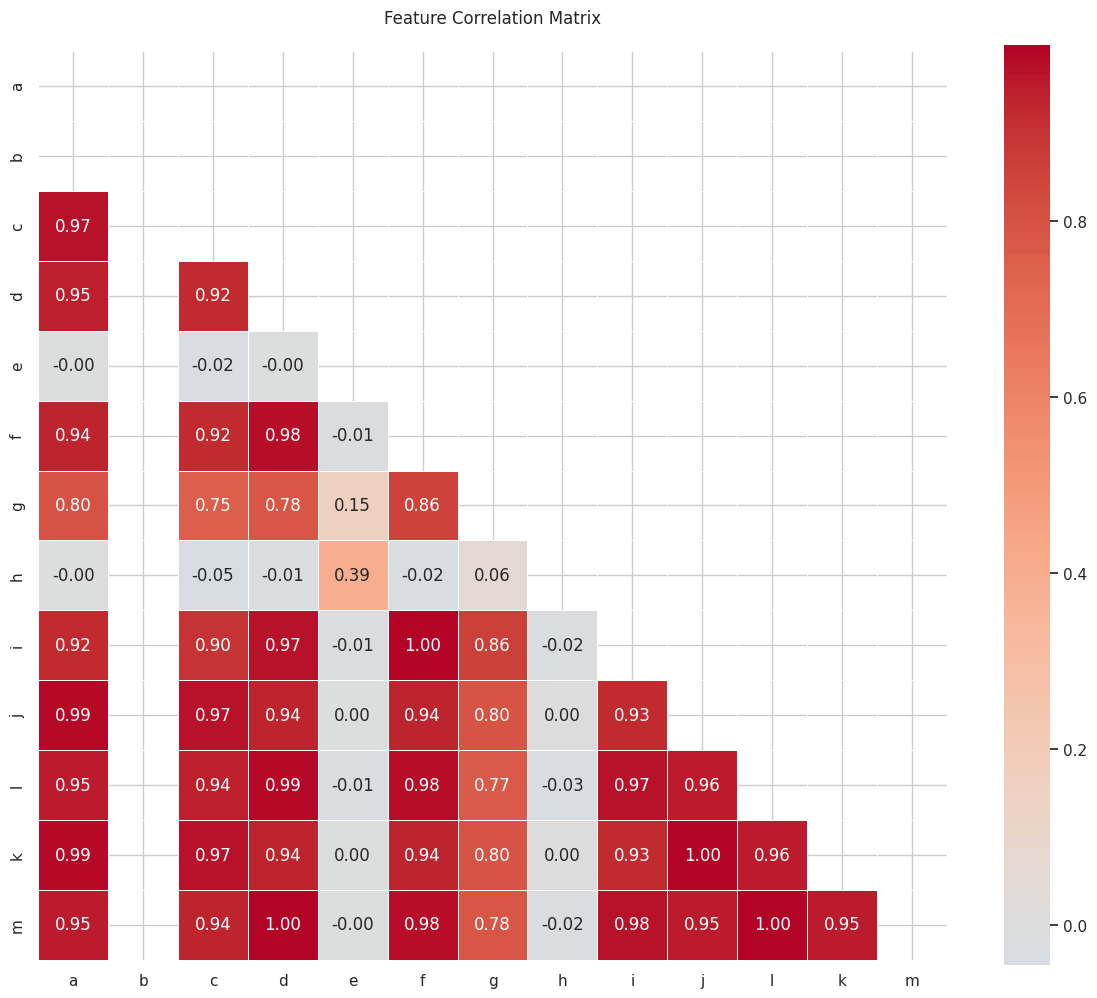

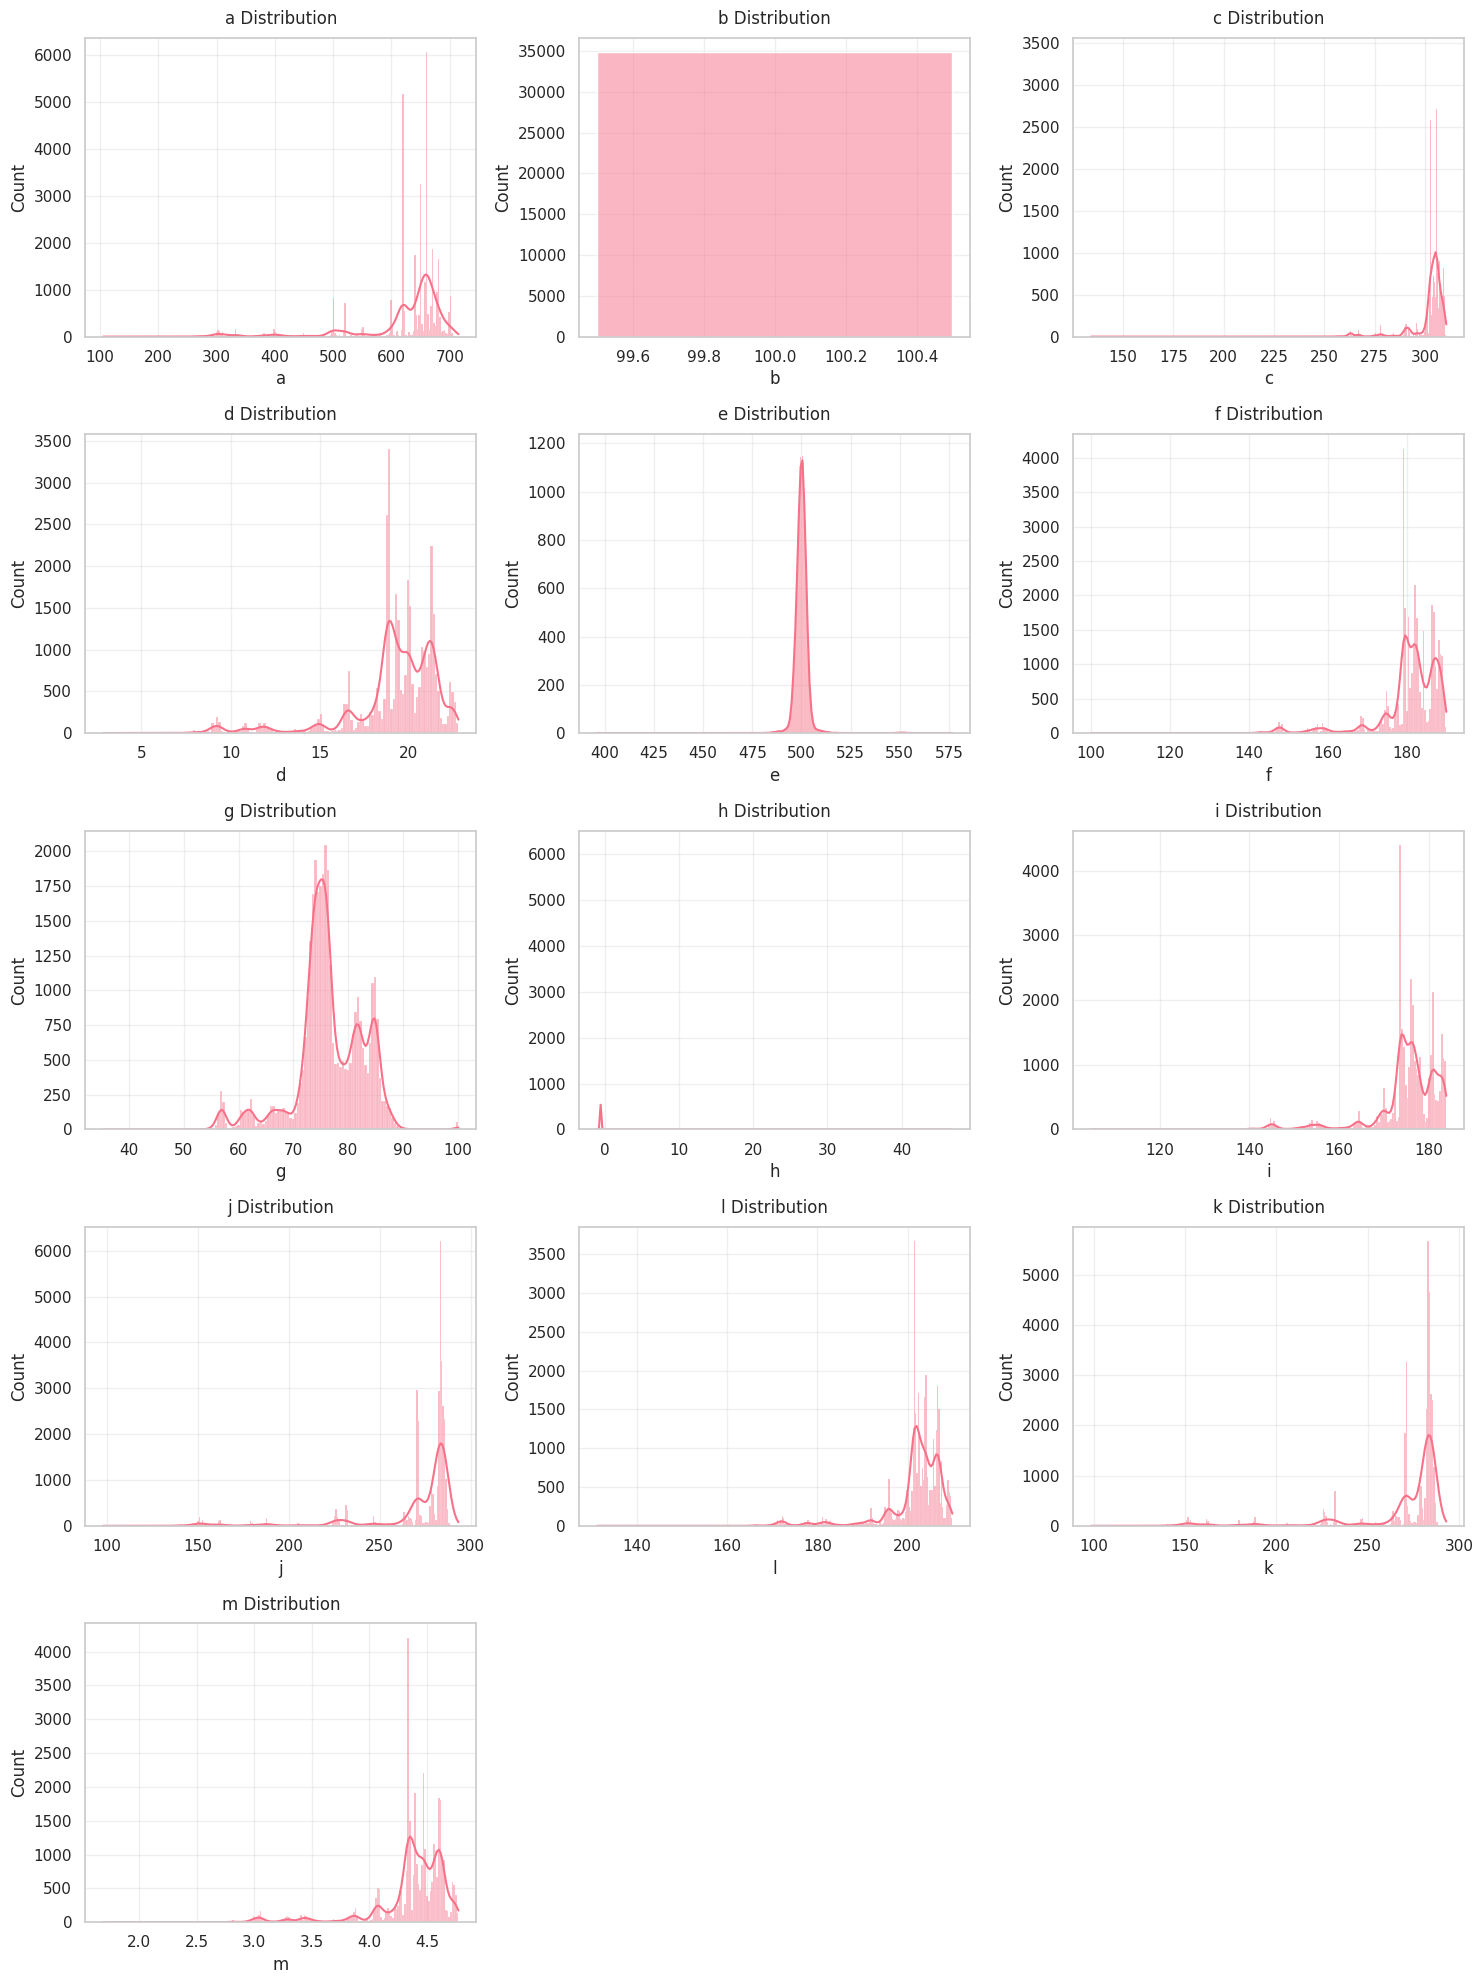

Epoch 1/50 [Validation]: 100%|██████████| 82/82 [00:00<00:00, 250.34it/s, loss=0.0019]



Epoch 1/50:
Training Loss: 0.2160, Accuracy: 0.9104, Precision: 0.9232, Recall: 0.9156, F1 Score: 0.9194
Validation Loss: 0.2606, Accuracy: 0.9199, Precision: 0.9145, Recall: 0.9726, F1 Score: 0.9427


Epoch 2/50 [Validation]: 100%|██████████| 82/82 [00:00<00:00, 275.31it/s, loss=0.0005]



Epoch 2/50:
Training Loss: 0.1143, Accuracy: 0.9603, Precision: 0.9644, Recall: 0.9645, F1 Score: 0.9645
Validation Loss: 0.2638, Accuracy: 0.9323, Precision: 0.9199, Recall: 0.9859, F1 Score: 0.9518


Epoch 3/50 [Validation]: 100%|██████████| 82/82 [00:00<00:00, 252.08it/s, loss=0.0015]



Epoch 3/50:
Training Loss: 0.0908, Accuracy: 0.9696, Precision: 0.9746, Recall: 0.9708, F1 Score: 0.9727
Validation Loss: 0.2604, Accuracy: 0.9373, Precision: 0.9194, Recall: 0.9946, F1 Score: 0.9555


Epoch 4/50 [Validation]: 100%|██████████| 82/82 [00:00<00:00, 250.09it/s, loss=0.0004]



Epoch 4/50:
Training Loss: 0.0765, Accuracy: 0.9747, Precision: 0.9803, Recall: 0.9742, F1 Score: 0.9772
Validation Loss: 0.1341, Accuracy: 0.9365, Precision: 0.9193, Recall: 0.9935, F1 Score: 0.9550


Epoch 5/50 [Validation]: 100%|██████████| 82/82 [00:00<00:00, 267.76it/s, loss=0.0069]



Epoch 5/50:
Training Loss: 0.0573, Accuracy: 0.9802, Precision: 0.9844, Recall: 0.9801, F1 Score: 0.9822
Validation Loss: 0.2726, Accuracy: 0.9352, Precision: 0.9209, Recall: 0.9893, F1 Score: 0.9539


Epoch 6/50 [Validation]: 100%|██████████| 82/82 [00:00<00:00, 284.15it/s, loss=0.0002]



Epoch 6/50:
Training Loss: 0.0477, Accuracy: 0.9835, Precision: 0.9857, Recall: 0.9847, F1 Score: 0.9852
Validation Loss: 0.5310, Accuracy: 0.9277, Precision: 0.9036, Recall: 1.0000, F1 Score: 0.9494


Epoch 7/50 [Validation]: 100%|██████████| 82/82 [00:00<00:00, 263.31it/s, loss=0.0013]



Epoch 7/50:
Training Loss: 0.0480, Accuracy: 0.9847, Precision: 0.9877, Recall: 0.9849, F1 Score: 0.9863
Validation Loss: 0.2101, Accuracy: 0.9403, Precision: 0.9224, Recall: 0.9958, F1 Score: 0.9577


Epoch 8/50 [Validation]: 100%|██████████| 82/82 [00:00<00:00, 265.12it/s, loss=0.0016]



Epoch 8/50:
Training Loss: 0.0444, Accuracy: 0.9856, Precision: 0.9882, Recall: 0.9861, F1 Score: 0.9871
Validation Loss: 0.2424, Accuracy: 0.9375, Precision: 0.9168, Recall: 0.9983, F1 Score: 0.9558


Epoch 9/50 [Validation]: 100%|██████████| 82/82 [00:00<00:00, 265.95it/s, loss=0.0008]



Epoch 9/50:
Training Loss: 0.0414, Accuracy: 0.9870, Precision: 0.9905, Recall: 0.9863, F1 Score: 0.9884
Validation Loss: 0.3908, Accuracy: 0.9392, Precision: 0.9218, Recall: 0.9946, F1 Score: 0.9568


Epoch 10/50 [Validation]: 100%|██████████| 82/82 [00:00<00:00, 268.88it/s, loss=0.0002]



Epoch 10/50:
Training Loss: 0.0396, Accuracy: 0.9877, Precision: 0.9907, Recall: 0.9872, F1 Score: 0.9889
Validation Loss: 0.4109, Accuracy: 0.9273, Precision: 0.9209, Recall: 0.9766, F1 Score: 0.9479


Epoch 11/50 [Validation]: 100%|██████████| 82/82 [00:00<00:00, 265.67it/s, loss=0.0002]



Epoch 11/50:
Training Loss: 0.0273, Accuracy: 0.9911, Precision: 0.9933, Recall: 0.9907, F1 Score: 0.9920
Validation Loss: 0.3186, Accuracy: 0.9371, Precision: 0.9152, Recall: 0.9997, F1 Score: 0.9556
Early stopping triggered


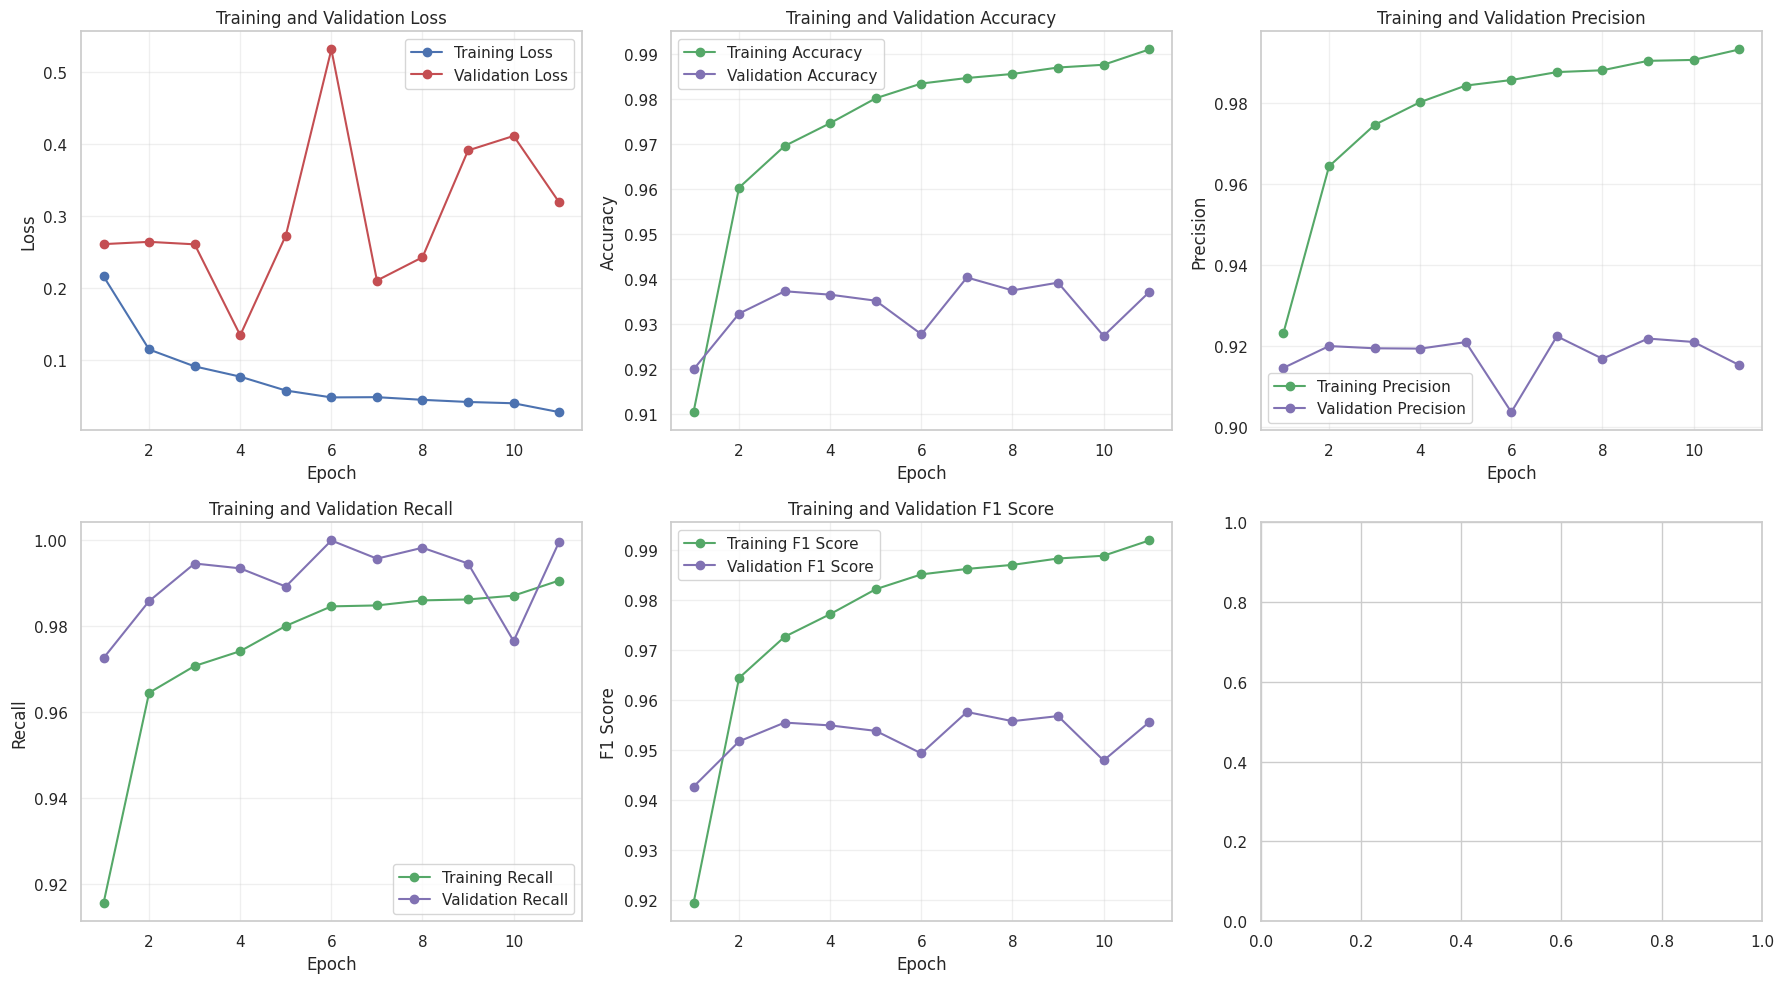

Predicting: 100%|██████████| 10895/10895 [00:15<00:00, 699.94it/s]


Match Percentage: 53.71%
Updated dataset saved as 'predictions_with_comparisons.csv'.


Epoch 1/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 202.85it/s, loss=0.4354]



Epoch 1/50:
Training Loss: 0.3949, Accuracy: 0.8005, Precision: 0.8197, Recall: 0.8710, F1 Score: 0.8445
Validation Loss: 0.3666, Accuracy: 0.8585, Precision: 0.8180, Recall: 0.9937, F1 Score: 0.8973


Epoch 2/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 201.64it/s, loss=0.2591]



Epoch 2/50:
Training Loss: 0.2131, Accuracy: 0.9157, Precision: 0.9182, Recall: 0.9491, F1 Score: 0.9334
Validation Loss: 0.2009, Accuracy: 0.9178, Precision: 0.8983, Recall: 0.9787, F1 Score: 0.9368


Epoch 3/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 185.85it/s, loss=0.2340]



Epoch 3/50:
Training Loss: 0.1702, Accuracy: 0.9388, Precision: 0.9412, Recall: 0.9617, F1 Score: 0.9513
Validation Loss: 0.1607, Accuracy: 0.9440, Precision: 0.9382, Recall: 0.9742, F1 Score: 0.9559


Epoch 4/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 225.76it/s, loss=0.1333]



Epoch 4/50:
Training Loss: 0.1475, Accuracy: 0.9475, Precision: 0.9487, Recall: 0.9679, F1 Score: 0.9582
Validation Loss: 0.1406, Accuracy: 0.9491, Precision: 0.9645, Recall: 0.9534, F1 Score: 0.9589


Epoch 5/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 191.28it/s, loss=0.1270]



Epoch 5/50:
Training Loss: 0.1282, Accuracy: 0.9522, Precision: 0.9567, Recall: 0.9669, F1 Score: 0.9618
Validation Loss: 0.1135, Accuracy: 0.9557, Precision: 0.9668, Recall: 0.9618, F1 Score: 0.9643


Epoch 6/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 202.52it/s, loss=0.0843]



Epoch 6/50:
Training Loss: 0.1091, Accuracy: 0.9603, Precision: 0.9657, Recall: 0.9706, F1 Score: 0.9682
Validation Loss: 0.0852, Accuracy: 0.9666, Precision: 0.9762, Recall: 0.9700, F1 Score: 0.9731


Epoch 7/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 191.03it/s, loss=0.0730]



Epoch 7/50:
Training Loss: 0.0967, Accuracy: 0.9641, Precision: 0.9686, Recall: 0.9738, F1 Score: 0.9712
Validation Loss: 0.1345, Accuracy: 0.9564, Precision: 0.9394, Recall: 0.9941, F1 Score: 0.9660


Epoch 8/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 193.67it/s, loss=0.1128]



Epoch 8/50:
Training Loss: 0.0891, Accuracy: 0.9677, Precision: 0.9724, Recall: 0.9758, F1 Score: 0.9741
Validation Loss: 0.0775, Accuracy: 0.9655, Precision: 0.9567, Recall: 0.9892, F1 Score: 0.9727


Epoch 9/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 170.64it/s, loss=0.0630]



Epoch 9/50:
Training Loss: 0.0791, Accuracy: 0.9706, Precision: 0.9746, Recall: 0.9782, F1 Score: 0.9764
Validation Loss: 0.0570, Accuracy: 0.9784, Precision: 0.9734, Recall: 0.9925, F1 Score: 0.9828


Epoch 10/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 193.34it/s, loss=0.0364]



Epoch 10/50:
Training Loss: 0.0680, Accuracy: 0.9757, Precision: 0.9794, Recall: 0.9816, F1 Score: 0.9805
Validation Loss: 0.0612, Accuracy: 0.9778, Precision: 0.9829, Recall: 0.9815, F1 Score: 0.9822


Epoch 11/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 193.67it/s, loss=0.0474]



Epoch 11/50:
Training Loss: 0.0624, Accuracy: 0.9762, Precision: 0.9802, Recall: 0.9817, F1 Score: 0.9809
Validation Loss: 0.0390, Accuracy: 0.9841, Precision: 0.9853, Recall: 0.9892, F1 Score: 0.9873


Epoch 12/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 194.37it/s, loss=0.1024]



Epoch 12/50:
Training Loss: 0.0560, Accuracy: 0.9797, Precision: 0.9831, Recall: 0.9843, F1 Score: 0.9837
Validation Loss: 0.0564, Accuracy: 0.9773, Precision: 0.9733, Recall: 0.9906, F1 Score: 0.9819


Epoch 13/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 203.58it/s, loss=0.1485]



Epoch 13/50:
Training Loss: 0.0523, Accuracy: 0.9807, Precision: 0.9848, Recall: 0.9841, F1 Score: 0.9845
Validation Loss: 0.0405, Accuracy: 0.9872, Precision: 0.9834, Recall: 0.9963, F1 Score: 0.9898


Epoch 14/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 219.08it/s, loss=0.0540]



Epoch 14/50:
Training Loss: 0.0498, Accuracy: 0.9826, Precision: 0.9864, Recall: 0.9856, F1 Score: 0.9860
Validation Loss: 0.0282, Accuracy: 0.9905, Precision: 0.9972, Recall: 0.9876, F1 Score: 0.9924


Epoch 15/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 210.44it/s, loss=0.0290]



Epoch 15/50:
Training Loss: 0.0433, Accuracy: 0.9853, Precision: 0.9881, Recall: 0.9883, F1 Score: 0.9882
Validation Loss: 0.0410, Accuracy: 0.9840, Precision: 0.9967, Recall: 0.9775, F1 Score: 0.9870


Epoch 16/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 203.48it/s, loss=0.0330]



Epoch 16/50:
Training Loss: 0.0437, Accuracy: 0.9845, Precision: 0.9876, Recall: 0.9874, F1 Score: 0.9875
Validation Loss: 0.0257, Accuracy: 0.9905, Precision: 0.9875, Recall: 0.9974, F1 Score: 0.9924


Epoch 17/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 199.33it/s, loss=0.0965]



Epoch 17/50:
Training Loss: 0.0457, Accuracy: 0.9851, Precision: 0.9883, Recall: 0.9877, F1 Score: 0.9880
Validation Loss: 0.0370, Accuracy: 0.9879, Precision: 0.9967, Recall: 0.9838, F1 Score: 0.9902


Epoch 18/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 192.94it/s, loss=0.0450]



Epoch 18/50:
Training Loss: 0.0422, Accuracy: 0.9854, Precision: 0.9886, Recall: 0.9880, F1 Score: 0.9883
Validation Loss: 0.0242, Accuracy: 0.9920, Precision: 0.9951, Recall: 0.9920, F1 Score: 0.9935


Epoch 19/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 201.89it/s, loss=0.1331]



Epoch 19/50:
Training Loss: 0.0373, Accuracy: 0.9869, Precision: 0.9893, Recall: 0.9897, F1 Score: 0.9895
Validation Loss: 0.0942, Accuracy: 0.9764, Precision: 0.9870, Recall: 0.9749, F1 Score: 0.9809


Epoch 20/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 200.57it/s, loss=0.1206]



Epoch 20/50:
Training Loss: 0.0469, Accuracy: 0.9853, Precision: 0.9879, Recall: 0.9886, F1 Score: 0.9882
Validation Loss: 0.0373, Accuracy: 0.9889, Precision: 0.9902, Recall: 0.9920, F1 Score: 0.9911


Epoch 21/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 195.55it/s, loss=0.0558]



Epoch 21/50:
Training Loss: 0.0372, Accuracy: 0.9875, Precision: 0.9903, Recall: 0.9897, F1 Score: 0.9900
Validation Loss: 0.0318, Accuracy: 0.9872, Precision: 0.9825, Recall: 0.9972, F1 Score: 0.9898


Epoch 22/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 191.05it/s, loss=0.0297]



Epoch 22/50:
Training Loss: 0.0308, Accuracy: 0.9893, Precision: 0.9914, Recall: 0.9914, F1 Score: 0.9914
Validation Loss: 0.0381, Accuracy: 0.9843, Precision: 0.9927, Recall: 0.9820, F1 Score: 0.9873


Epoch 23/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 191.61it/s, loss=0.0062]



Epoch 23/50:
Training Loss: 0.0303, Accuracy: 0.9898, Precision: 0.9931, Recall: 0.9904, F1 Score: 0.9918
Validation Loss: 0.0453, Accuracy: 0.9897, Precision: 0.9925, Recall: 0.9909, F1 Score: 0.9917


Epoch 24/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 202.66it/s, loss=0.0301]



Epoch 24/50:
Training Loss: 0.0311, Accuracy: 0.9895, Precision: 0.9919, Recall: 0.9912, F1 Score: 0.9915
Validation Loss: 0.0203, Accuracy: 0.9921, Precision: 0.9916, Recall: 0.9958, F1 Score: 0.9937


Epoch 25/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 195.10it/s, loss=0.0849]



Epoch 25/50:
Training Loss: 0.0312, Accuracy: 0.9894, Precision: 0.9912, Recall: 0.9918, F1 Score: 0.9915
Validation Loss: 0.0215, Accuracy: 0.9924, Precision: 0.9902, Recall: 0.9977, F1 Score: 0.9939


Epoch 26/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 229.75it/s, loss=0.0659]



Epoch 26/50:
Training Loss: 0.0319, Accuracy: 0.9883, Precision: 0.9901, Recall: 0.9911, F1 Score: 0.9906
Validation Loss: 0.0555, Accuracy: 0.9837, Precision: 0.9885, Recall: 0.9852, F1 Score: 0.9869


Epoch 27/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 203.10it/s, loss=0.0169]



Epoch 27/50:
Training Loss: 0.0293, Accuracy: 0.9897, Precision: 0.9919, Recall: 0.9915, F1 Score: 0.9917
Validation Loss: 0.0314, Accuracy: 0.9905, Precision: 0.9972, Recall: 0.9876, F1 Score: 0.9924


Epoch 28/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 211.34it/s, loss=0.0391]



Epoch 28/50:
Training Loss: 0.0286, Accuracy: 0.9905, Precision: 0.9921, Recall: 0.9926, F1 Score: 0.9924
Validation Loss: 0.0172, Accuracy: 0.9933, Precision: 0.9909, Recall: 0.9984, F1 Score: 0.9946


Epoch 29/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 219.52it/s, loss=0.0512]



Epoch 29/50:
Training Loss: 0.0257, Accuracy: 0.9916, Precision: 0.9936, Recall: 0.9929, F1 Score: 0.9932
Validation Loss: 0.1109, Accuracy: 0.9755, Precision: 0.9945, Recall: 0.9660, F1 Score: 0.9800


Epoch 30/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 199.06it/s, loss=0.0446]



Epoch 30/50:
Training Loss: 0.0298, Accuracy: 0.9904, Precision: 0.9926, Recall: 0.9919, F1 Score: 0.9923
Validation Loss: 0.0251, Accuracy: 0.9923, Precision: 0.9930, Recall: 0.9946, F1 Score: 0.9938


Epoch 31/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 206.86it/s, loss=0.0337]



Epoch 31/50:
Training Loss: 0.0283, Accuracy: 0.9908, Precision: 0.9924, Recall: 0.9927, F1 Score: 0.9926
Validation Loss: 0.0116, Accuracy: 0.9966, Precision: 0.9974, Recall: 0.9972, F1 Score: 0.9973


Epoch 32/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 201.11it/s, loss=0.0503]



Epoch 32/50:
Training Loss: 0.0248, Accuracy: 0.9917, Precision: 0.9936, Recall: 0.9931, F1 Score: 0.9933
Validation Loss: 0.0247, Accuracy: 0.9917, Precision: 0.9895, Recall: 0.9972, F1 Score: 0.9933


Epoch 33/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 197.34it/s, loss=0.0992]



Epoch 33/50:
Training Loss: 0.0273, Accuracy: 0.9911, Precision: 0.9936, Recall: 0.9920, F1 Score: 0.9928
Validation Loss: 0.0302, Accuracy: 0.9895, Precision: 0.9990, Recall: 0.9841, F1 Score: 0.9915


Epoch 34/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 210.04it/s, loss=0.0413]



Epoch 34/50:
Training Loss: 0.0262, Accuracy: 0.9909, Precision: 0.9932, Recall: 0.9922, F1 Score: 0.9927
Validation Loss: 0.0140, Accuracy: 0.9939, Precision: 0.9946, Recall: 0.9955, F1 Score: 0.9951


Epoch 35/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 200.47it/s, loss=0.0240]



Epoch 35/50:
Training Loss: 0.0252, Accuracy: 0.9921, Precision: 0.9936, Recall: 0.9937, F1 Score: 0.9937
Validation Loss: 0.0182, Accuracy: 0.9929, Precision: 0.9976, Recall: 0.9909, F1 Score: 0.9942


Epoch 36/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 201.35it/s, loss=0.0279]



Epoch 36/50:
Training Loss: 0.0279, Accuracy: 0.9915, Precision: 0.9928, Recall: 0.9936, F1 Score: 0.9932
Validation Loss: 0.0142, Accuracy: 0.9945, Precision: 0.9962, Recall: 0.9948, F1 Score: 0.9955


Epoch 37/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 192.49it/s, loss=0.0160]



Epoch 37/50:
Training Loss: 0.0253, Accuracy: 0.9929, Precision: 0.9946, Recall: 0.9940, F1 Score: 0.9943
Validation Loss: 0.0263, Accuracy: 0.9924, Precision: 0.9979, Recall: 0.9899, F1 Score: 0.9939


Epoch 38/50 [Validation]: 100%|██████████| 54/54 [00:00<00:00, 209.58it/s, loss=0.0380]



Epoch 38/50:
Training Loss: 0.0167, Accuracy: 0.9939, Precision: 0.9958, Recall: 0.9945, F1 Score: 0.9951
Validation Loss: 0.0154, Accuracy: 0.9952, Precision: 0.9958, Recall: 0.9965, F1 Score: 0.9961
Early stopping triggered


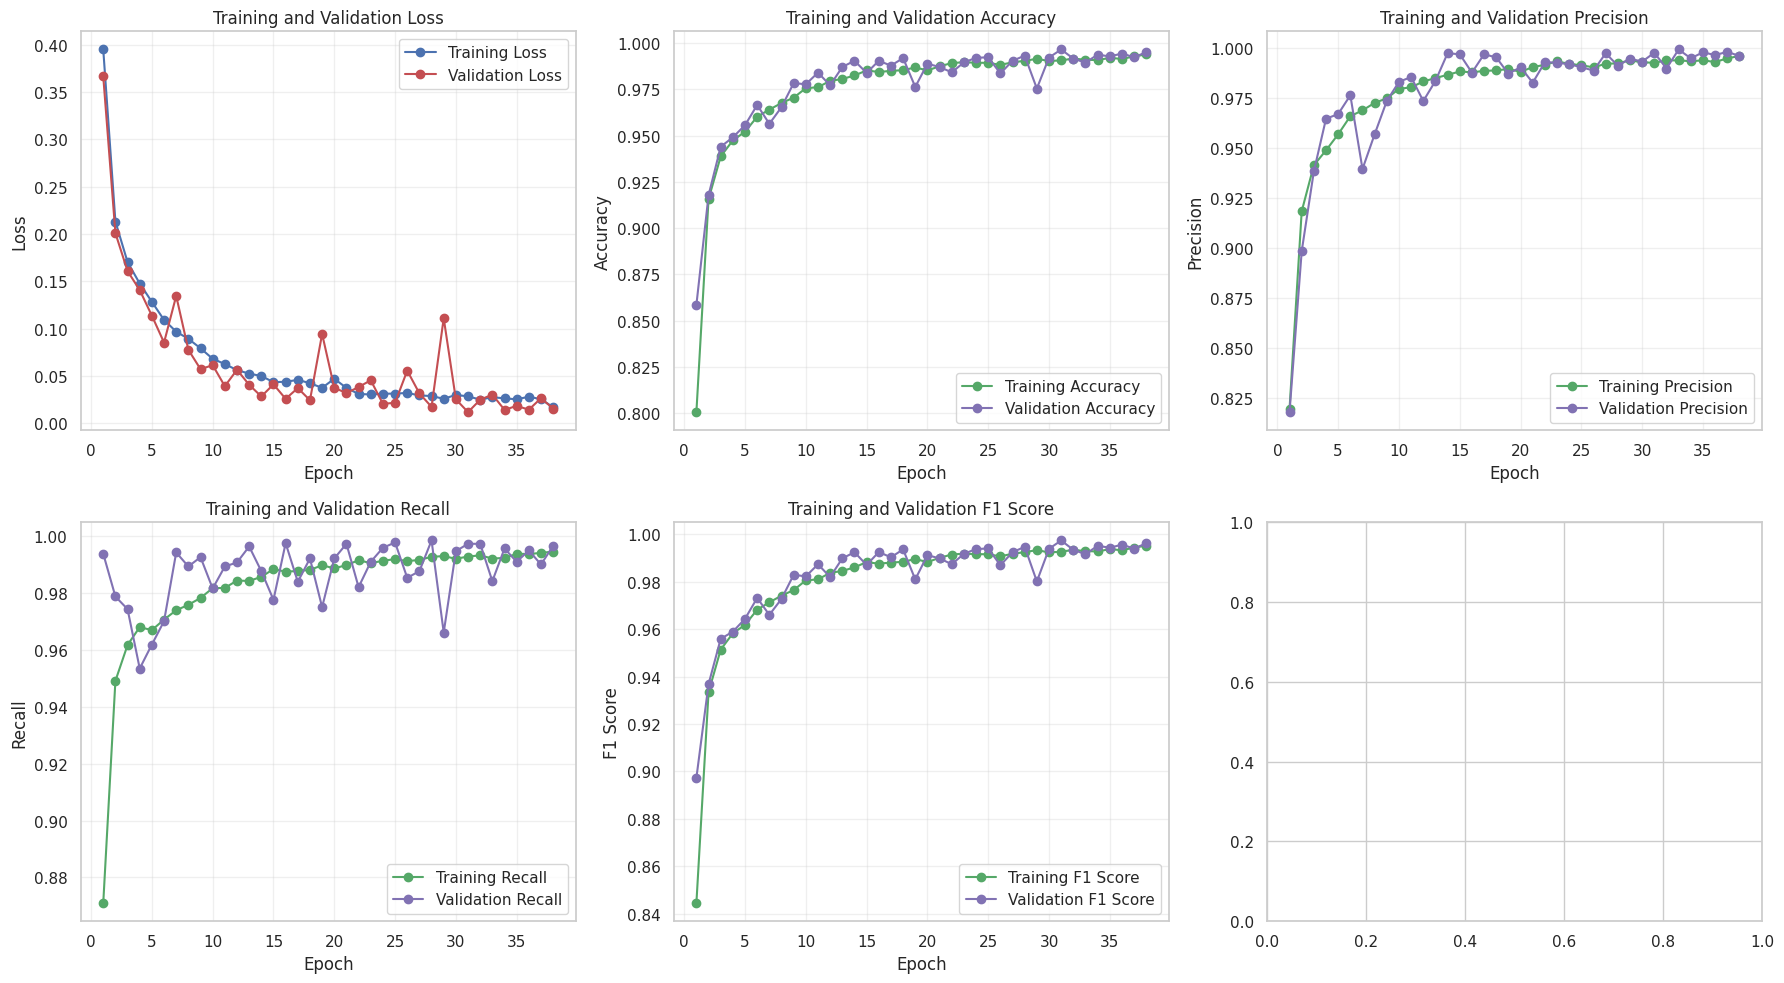

Predicting 13.csv: 100%|██████████| 3069/3069 [00:04<00:00, 697.87it/s]


Updated dataset saved as '13_updated.csv'.
Match Percentage for 13.csv: 97.43%


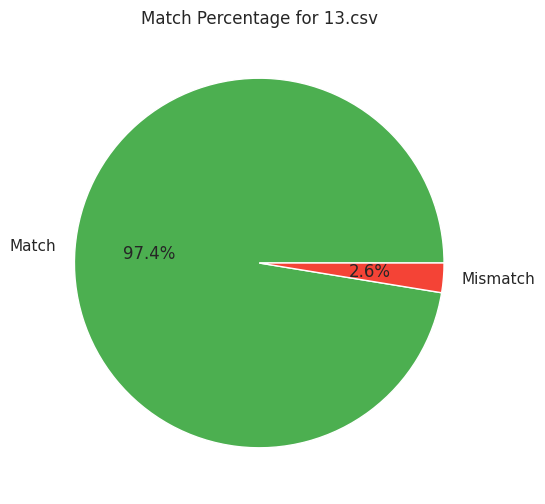

Predicting 43.csv: 100%|██████████| 1846/1846 [00:02<00:00, 691.34it/s]


Updated dataset saved as '43_updated.csv'.
Match Percentage for 43.csv: 93.88%


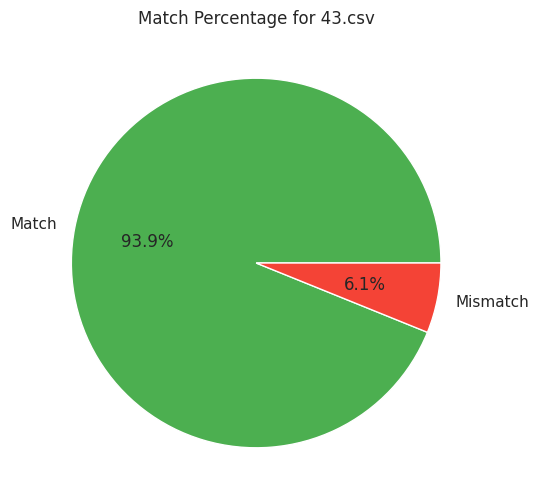

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from tqdm.auto import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

# Set style for all plots
sns.set_theme(style="whitegrid")
sns.set_palette("husl")

# Enable GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def plot_correlation_matrix(data, features):
    """Plot correlation matrix of features"""
    plt.figure(figsize=(12, 10))
    correlation_matrix = data[features].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True, linewidths=0.5)
    plt.title('Feature Correlation Matrix', pad=20)
    plt.tight_layout()
    plt.show()

def plot_feature_distributions(data, features):
    """Plot distribution of each feature with improved styling"""
    n_features = len(features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(15, n_rows * 4))
    for i, feature in enumerate(features, 1):
        ax = plt.subplot(n_rows, n_cols, i)
        sns.histplot(data[feature], kde=True, ax=ax)
        ax.set_title(f'{feature} Distribution', pad=10)
        ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

from sklearn.metrics import precision_score, recall_score, f1_score

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, device, patience=7):
    model = model.to(device)
    early_stopping = EarlyStopping(patience=patience)
    
    train_losses = []
    val_losses = []
    train_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    val_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        train_predictions = []
        train_targets = []
        
        # Use tqdm for progress bar
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]')
        for sequences, labels in train_pbar:
            sequences, labels = sequences.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs.squeeze(), labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
            train_predictions.extend((outputs.squeeze() > 0.5).cpu().detach().numpy())
            train_targets.extend(labels.cpu().numpy())
            
            # Update progress bar
            train_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = accuracy_score(train_targets, train_predictions)
        train_precision = precision_score(train_targets, train_predictions)
        train_recall = recall_score(train_targets, train_predictions)
        train_f1 = f1_score(train_targets, train_predictions)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        val_predictions = []
        val_targets = []
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]')
            for sequences, labels in val_pbar:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs.squeeze(), labels)
                
                total_val_loss += loss.item()
                val_predictions.extend((outputs.squeeze() > 0.5).cpu().numpy())
                val_targets.extend(labels.cpu().numpy())
                
                # Update progress bar
                val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_targets, val_predictions)
        val_precision = precision_score(val_targets, val_predictions)
        val_recall = recall_score(val_targets, val_predictions)
        val_f1 = f1_score(val_targets, val_predictions)
        
        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_metrics['accuracy'].append(train_accuracy)
        train_metrics['precision'].append(train_precision)
        train_metrics['recall'].append(train_recall)
        train_metrics['f1'].append(train_f1)
        val_metrics['accuracy'].append(val_accuracy)
        val_metrics['precision'].append(val_precision)
        val_metrics['recall'].append(val_recall)
        val_metrics['f1'].append(val_f1)
        
        # Print epoch results
        print(f'\nEpoch {epoch+1}/{num_epochs}:')
        print(f'Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping
        early_stopping(avg_val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    return train_losses, val_losses, train_metrics, val_metrics

def plot_learning_curves(train_losses, val_losses, train_metrics, val_metrics):
    """Plot training and validation curves with metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot losses
    epochs = range(1, len(train_losses) + 1)
    axes[0, 0].plot(epochs, train_losses, 'b-', label='Training Loss', marker='o')
    axes[0, 0].plot(epochs, val_losses, 'r-', label='Validation Loss', marker='o')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot accuracy
    axes[0, 1].plot(epochs, train_metrics['accuracy'], 'g-', label='Training Accuracy', marker='o')
    axes[0, 1].plot(epochs, val_metrics['accuracy'], 'm-', label='Validation Accuracy', marker='o')
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot precision
    axes[0, 2].plot(epochs, train_metrics['precision'], 'g-', label='Training Precision', marker='o')
    axes[0, 2].plot(epochs, val_metrics['precision'], 'm-', label='Validation Precision', marker='o')
    axes[0, 2].set_title('Training and Validation Precision')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot recall
    axes[1, 0].plot(epochs, train_metrics['recall'], 'g-', label='Training Recall', marker='o')
    axes[1, 0].plot(epochs, val_metrics['recall'], 'm-', label='Validation Recall', marker='o')
    axes[1, 0].set_title('Training and Validation Recall')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Recall')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot F1 score
    axes[1, 1].plot(epochs, train_metrics['f1'], 'g-', label='Training F1 Score', marker='o')
    axes[1, 1].plot(epochs, val_metrics['f1'], 'm-', label='Validation F1 Score', marker='o')
    axes[1, 1].set_title('Training and Validation F1 Score')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

class RNNTransformer(nn.Module):
    def __init__(self, input_dim, rnn_hidden_dim, transformer_dim, n_heads, n_layers, dropout=0.2):
        super().__init__()
        
        # LSTM layer with increased hidden dimensions
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=rnn_hidden_dim,
            num_layers=3,  # Increase layers for better feature extraction
            batch_first=True,
            dropout=dropout,
            bidirectional=True
        )
        
        # Linear layer to transform LSTM output to transformer dimension
        lstm_output_dim = rnn_hidden_dim * 2
        self.fc_lstm_to_transformer = nn.Linear(lstm_output_dim, transformer_dim)
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, 500, transformer_dim))  # Adjust sequence max length
        
        # Layer normalization and dropout
        self.layer_norm1 = nn.LayerNorm(transformer_dim)
        self.dropout1 = nn.Dropout(dropout)
        
        # Transformer layers with increased dimensions
        transformer_layer = nn.TransformerEncoderLayer(
            d_model=transformer_dim,
            nhead=n_heads,
            dim_feedforward=transformer_dim * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(transformer_layer, n_layers)
        
        # Output layers
        self.fc1 = nn.Linear(transformer_dim, transformer_dim // 2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(transformer_dim // 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # LSTM
        lstm_out, _ = self.lstm(x)
        
        # Transform to transformer dimension
        transformer_input = self.fc_lstm_to_transformer(lstm_out)
        transformer_input += self.positional_encoding[:, :transformer_input.size(1), :]
        transformer_input = self.layer_norm1(transformer_input)
        transformer_input = self.dropout1(transformer_input)
        
        # Transformer
        transformer_out = self.transformer_encoder(transformer_input)
        
        # Global average pooling
        pooled = torch.mean(transformer_out, dim=1)
        
        # Output layers
        out = self.fc1(pooled)
        out = F.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        
        return out


def main():
    # Load and preprocess data
    data = pd.read_csv('49.csv')  # Replace with your training file
    features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
    target = 'o'
    
    # Plot initial data analysis
    plot_correlation_matrix(data, features)
    plot_feature_distributions(data, features)
    
    # Normalize features
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])
    
    # Prepare sequences
    sequence_length = 10
    sequences, labels = create_sequences(data, sequence_length, target, features)
    
    # Split data
    train_ratio = 0.7
    val_ratio = 0.15
    train_size = int(len(sequences) * train_ratio)
    val_size = int(len(sequences) * val_ratio)
    
    train_sequences = sequences[:train_size]
    train_labels = labels[:train_size]
    val_sequences = sequences[train_size:train_size+val_size]
    val_labels = labels[train_size:train_size+val_size]
    test_sequences = sequences[train_size+val_size:]
    test_labels = labels[train_size+val_size:]
    
    # Create datasets and dataloaders
    train_dataset = TimeSeriesDataset(train_sequences, train_labels)
    val_dataset = TimeSeriesDataset(val_sequences, val_labels)
    test_dataset = TimeSeriesDataset(test_sequences, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Initialize model and training components
    model = RNNTransformer(
        input_dim=len(features),
        rnn_hidden_dim=128,
        transformer_dim=256,
        n_heads=8,
        n_layers=4,
        dropout=0.1
    )
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)


    # Train model
    train_losses, val_losses, train_metrics, val_metrics = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=50,
        device=device,
        patience=7
    )
    
    # Plot learning curves
    plot_learning_curves(train_losses, val_losses, train_metrics, val_metrics)
    
    return model, scaler

def create_sequences(data, sequence_length, target_col, features):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        seq = data[features].iloc[i:i+sequence_length].values
        label = data[target_col].iloc[i + sequence_length - 1]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)



# Ensure all the previous imports and classes remain the same

def predict_new_data(model, scaler, pred_file, sequence_length=10):
    """
    Predicts 'o' column in the given prediction dataset and compares actual vs. predicted values.
    
    Args:
        model: Trained PyTorch model.
        scaler: Fitted Scaler for normalization.
        pred_file: File path for the new prediction dataset.
        sequence_length: Sequence length for prediction.
    
    Returns:
        None. Outputs predictions and match percentage.
    """
    # Load prediction dataset
    pred_data = pd.read_csv(pred_file)
    features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
    target_col = 'o'

    # Normalize features
    pred_data[features] = scaler.transform(pred_data[features])

    # Prepare sequences for prediction
    sequences = []
    for i in range(len(pred_data) - sequence_length):
        seq = pred_data[features].iloc[i:i + sequence_length].values
        sequences.append(seq)
    sequences = np.array(sequences)

    # Perform prediction
    model.eval()
    predictions = []
    with torch.no_grad():
        for seq in tqdm(sequences, desc="Predicting"):
            seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
            pred = model(seq_tensor)
            predictions.append((pred.squeeze().item() > 0.5) * 1.0)  # Binary prediction

    # Add predictions to dataset
    pred_column_name = f'Prediction_{model.__class__.__name__}'
    pred_data[pred_column_name] = np.nan
    pred_data.loc[sequence_length:, pred_column_name] = predictions

    # Compare with actual 'o' values
    actual = pred_data[target_col].iloc[sequence_length:].values
    predicted = np.array(predictions)
    match_count = np.sum(actual == predicted)
    match_percentage = (match_count / len(predicted)) * 100

    print(f"Match Percentage: {match_percentage:.2f}%")
    
    # Save predictions to a new file
    pred_data.to_csv("predictions_with_comparisons.csv", index=False)
    print("Updated dataset saved as 'predictions_with_comparisons.csv'.")

# Main function updated to call the prediction feature
def main():
    # Load and preprocess training data
    data = pd.read_csv('49.csv')  # Replace with your training file
    features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
    target = 'o'

    # Plot initial data analysis
    plot_correlation_matrix(data, features)
    plot_feature_distributions(data, features)

    # Normalize features
    scaler = StandardScaler()
    data[features] = scaler.fit_transform(data[features])

    # Prepare sequences
    sequence_length = 10
    sequences, labels = create_sequences(data, sequence_length, target, features)

    # Split data
    train_ratio = 0.7
    val_ratio = 0.15
    train_size = int(len(sequences) * train_ratio)
    val_size = int(len(sequences) * val_ratio)

    train_sequences = sequences[:train_size]
    train_labels = labels[:train_size]
    val_sequences = sequences[train_size:train_size+val_size]
    val_labels = labels[train_size:train_size+val_size]
    test_sequences = sequences[train_size+val_size:]
    test_labels = labels[train_size+val_size:]

    # Create datasets and dataloaders
    train_dataset = TimeSeriesDataset(train_sequences, train_labels)
    val_dataset = TimeSeriesDataset(val_sequences, val_labels)
    test_dataset = TimeSeriesDataset(test_sequences, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize model and training components
    model = RNNTransformer(
        input_dim=len(features),
        rnn_hidden_dim=128,
        transformer_dim=256,
        n_heads=8,
        n_layers=4,
        dropout=0.1
    )
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Train model
    train_losses, val_losses, train_metrics, val_metrics = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=50,
        device=device,
        patience=7
    )

    # Plot learning curves
    plot_learning_curves(train_losses, val_losses, train_metrics, val_metrics)

    # Predict on new data
    predict_new_data(model, scaler, pred_file='28.csv', sequence_length=sequence_length)

    return model, scaler

if __name__ == "__main__":
    model, scaler = main()

import os
import random
from sklearn.model_selection import train_test_split

def load_and_preprocess_data(file_paths, features, target, sequence_length):
    all_sequences = []
    all_labels = []
    
    for file_path in file_paths:
        data = pd.read_csv(file_path)
        
        # Normalize features
        scaler = StandardScaler()
        data[features] = scaler.fit_transform(data[features])
        
        # Prepare sequences
        sequences, labels = create_sequences(data, sequence_length, target, features)
        all_sequences.extend(sequences)
        all_labels.extend(labels)
    
    return np.array(all_sequences), np.array(all_labels), scaler

def train_model_with_multiple_files(model, file_paths, features, target, sequence_length, 
                                    criterion, optimizer, scheduler, num_epochs, device, patience=7):
    all_sequences, all_labels, scaler = load_and_preprocess_data(file_paths, features, target, sequence_length)
    
    # Stratified split
    train_sequences, temp_sequences, train_labels, temp_labels = train_test_split(
        all_sequences, all_labels, test_size=0.3, stratify=all_labels, random_state=42)
    val_sequences, test_sequences, val_labels, test_labels = train_test_split(
        temp_sequences, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)
    
    # Create datasets and dataloaders
    train_dataset = TimeSeriesDataset(train_sequences, train_labels)
    val_dataset = TimeSeriesDataset(val_sequences, val_labels)
    test_dataset = TimeSeriesDataset(test_sequences, test_labels)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Train model
    train_losses, val_losses, train_metrics, val_metrics = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=num_epochs,
        device=device,
        patience=patience
    )
    
    return model, scaler, train_losses, val_losses, train_metrics, val_metrics

def test_model_with_multiple_files(model, scaler, test_file_paths, sequence_length, device):
    for test_file in test_file_paths:
        pred_data = pd.read_csv(test_file)
        features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
        target_col = 'o'
        
        # Normalize features
        pred_data[features] = scaler.transform(pred_data[features])
        
        # Prepare sequences for prediction
        sequences = []
        for i in range(len(pred_data) - sequence_length):
            seq = pred_data[features].iloc[i:i + sequence_length].values
            sequences.append(seq)
        sequences = np.array(sequences)
        
        # Perform prediction
        model.eval()
        predictions = []
        with torch.no_grad():
            for seq in tqdm(sequences, desc=f"Predicting {test_file}"):
                seq_tensor = torch.tensor(seq, dtype=torch.float32).unsqueeze(0).to(device)
                pred = model(seq_tensor)
                predictions.append((pred.squeeze().item() > 0.5) * 1.0)  # Binary prediction
        
        # Add predictions to dataset
        pred_column_name = f'Prediction_{model.__class__.__name__}'
        pred_data[pred_column_name] = np.nan
        pred_data.loc[sequence_length:, pred_column_name] = predictions
        
        # Save predictions to a new file
        output_file = test_file.replace('.csv', '_updated.csv')
        pred_data.to_csv(output_file, index=False)
        print(f"Updated dataset saved as '{output_file}'.")
        
        # Compare with actual 'o' values
        actual = pred_data[target_col].iloc[sequence_length:].values
        predicted = np.array(predictions)
        match_count = np.sum(actual == predicted)
        match_percentage = (match_count / len(predicted)) * 100
        
        print(f"Match Percentage for {test_file}: {match_percentage:.2f}%")
        
        # Visualize match percentage
        visualize_match_percentage(actual, predicted, test_file)

def visualize_match_percentage(actual, predicted, file_name):
    match_percentage = np.sum(actual == predicted) / len(predicted) * 100
    plt.figure(figsize=(6, 6))
    plt.pie([match_percentage, 100 - match_percentage], labels=['Match', 'Mismatch'], autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
    plt.title(f'Match Percentage for {file_name}')
    plt.show()

def main():
    # Define training files
    training_files = ['28.csv', '49.csv']  # Replace with your training files
    features = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'k', 'm']
    target = 'o'
    sequence_length = 10
    
    # Initialize model and training components
    model = RNNTransformer(
        input_dim=len(features),
        rnn_hidden_dim=128,
        transformer_dim=256,
        n_heads=8,
        n_layers=4,
        dropout=0.1
    )
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    
    # Train model with multiple files
    model, scaler, train_losses, val_losses, train_metrics, val_metrics = train_model_with_multiple_files(
        model=model,
        file_paths=training_files,
        features=features,
        target=target,
        sequence_length=sequence_length,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        num_epochs=50,
        device=device,
        patience=7
    )
    
    # Plot learning curves
    plot_learning_curves(train_losses, val_losses, train_metrics, val_metrics)
    
    # Define test files
    test_files = ['13.csv', '43.csv']  # Replace with your test files
    
    # Test model with multiple files
    test_model_with_multiple_files(model, scaler, test_files, sequence_length, device)

if __name__ == "__main__":
    main()


/tmp/ipykernel_2017677/752143727.py:5: DtypeWarning: Columns (5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dara.csv')


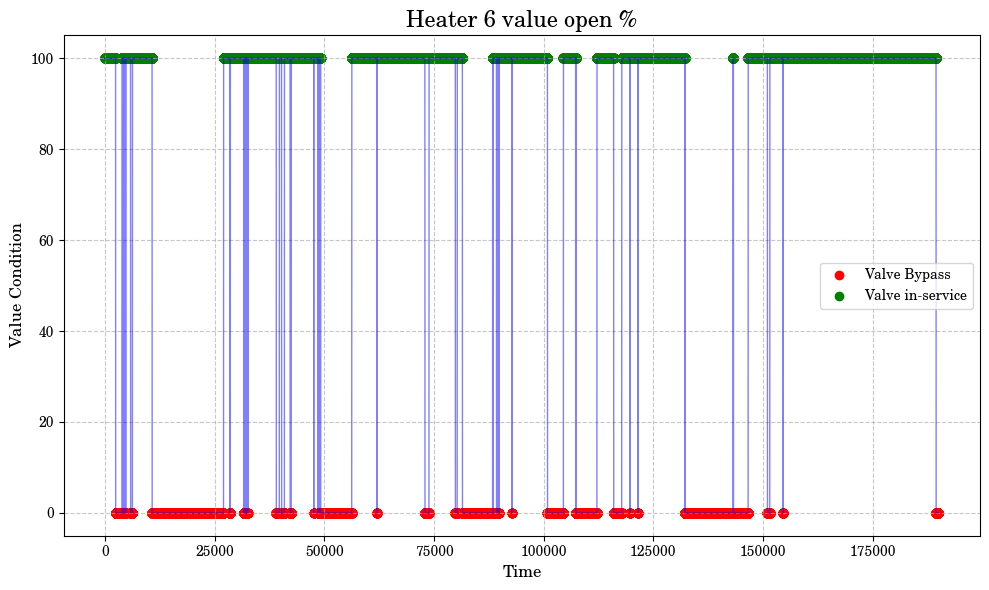

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Load the data
data = pd.read_csv('dara.csv')

# Define the column name you want to filter and plot
column_name = 'Heater 6 MOV open status'  # Replace with your actual column name

# Filter the data based on the column values
filtered_data = data[(data[column_name] == 0) | (data[column_name] == 100)]

# Create a time series or index based on your data (if applicable)
# If you don't have a specific time column, we can use the row number as x-axis
x = filtered_data.index
y = filtered_data[column_name]

# Set the figure size for better clarity
plt.figure(figsize=(10, 6))

# Plot the data points
plt.scatter(x[y == 0], y[y == 0], c='red', label='Valve Bypass', marker='o')
plt.scatter(x[y == 100], y[y == 100], c='green', label='Valve in-service', marker='o')

# Connect the points with a line
plt.plot(x, y, color='blue', alpha=0.5, linestyle='-', linewidth=1)

# Customize the plot for a beautiful design
plt.title('Heater 6 value open %', fontsize=16, family='C059')
plt.xlabel('Time', fontsize=12, family='C059')
plt.ylabel('Value Condition', fontsize=12, family='C059')
plt.xticks(fontsize=10, family='C059')
plt.yticks(fontsize=10, family='C059')

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add a legend
plt.legend(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


/tmp/ipykernel_2017677/2389819081.py:5: DtypeWarning: Columns (5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dara.csv')


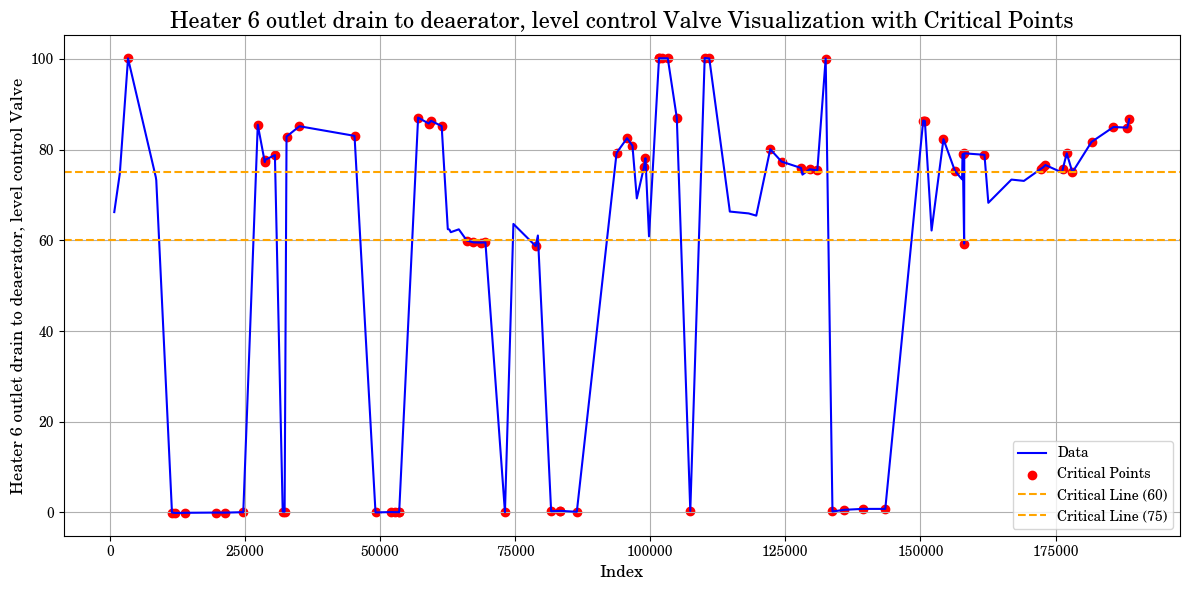

Best sample to represent the data:
               Description   Turbine output   Heater 6 MOV open status  \
103236  03/22/2020 08:20:00            -0.16                       0.0   

        Heate 6 extraction inlet steam temp from heater 9  \
103236                                              33.98   

        Heater 6 extraction steam inlet pressure from heater 9  \
103236                                               0.54        

       Heater 6 condensation level  \
103236                      549.72   

        Heater 6 outlet temp to dearator ( drain temp)  \
103236                                           33.98   

        Heater 6 outlet drain to deaerator, level control Valve  \
103236                                             100.14         

        Heater 6 outlet drain to deaerator, level control Valve emergency  \
103236                                              -0.42                   

        heater # 6 water inlet temp   ...  heater # 6 water outlet pressure 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('dara.csv')

# Define the column to visualize
column_name = 'Heater 6 outlet drain to deaerator, level control Valve'

# Sample a smaller subset of the data for better visualization
sampled_data = data.sample(n=100, random_state=42).sort_index()

# Identify critical points
critical_points = sampled_data[(sampled_data[column_name] < 60) | (sampled_data[column_name] > 75)]

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(sampled_data.index, sampled_data[column_name], label='Data', color='blue')
plt.scatter(critical_points.index, critical_points[column_name], color='red', label='Critical Points')

# Add critical lines
plt.axhline(y=60, color='orange', linestyle='--', label='Critical Line (60)')
plt.axhline(y=75, color='orange', linestyle='--', label='Critical Line (75)')

# Customize the plot
plt.title(f'{column_name} Visualization with Critical Points', fontsize=16, family='C059')
plt.xlabel('Index', fontsize=12, family='C059')
plt.ylabel(column_name, fontsize=12, family='C059')
plt.legend(prop={'family': 'C059'})
plt.grid(True)
plt.xticks(fontsize=10, family='C059')
plt.yticks(fontsize=10, family='C059')
plt.tight_layout()

# Show the plot
plt.show()

# Pick the best sample to represent the data
best_sample = critical_points.sample(n=1)
print("Best sample to represent the data:")
print(best_sample)

/tmp/ipykernel_2017677/85069903.py:5: DtypeWarning: Columns (5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dara.csv')


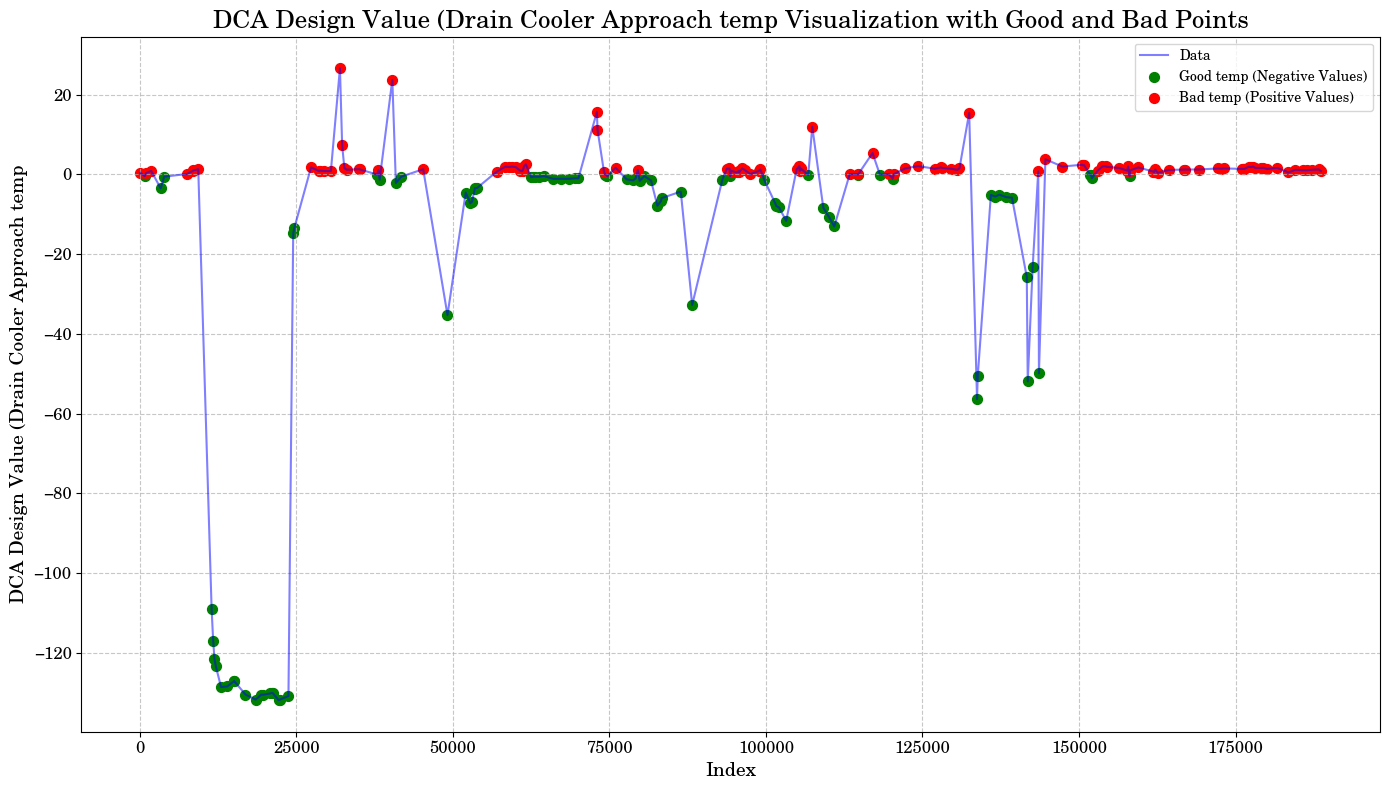

Best sample to represent the data:
Description                                                          09/02/2018 03:40:00
Turbine output                                                                     580.6
Heater 6 MOV open status                                                             0.0
Heate 6 extraction inlet steam temp from heater 9                                  43.72
Heater 6 extraction steam inlet pressure from heater 9                              0.03
Heater 6 condensation level                                                        -0.01
Heater 6 outlet temp to dearator ( drain temp)                                     43.98
Heater 6 outlet drain to deaerator, level control Valve                             -0.1
Heater 6 outlet drain to deaerator, level control Valve emergency                  -0.55
heater # 6 water inlet temp                                                        171.3
heater # 6 water inlet pressure                                            

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('dara.csv')

# Define the column to visualize
column_name = 'DCA Design Value (Drain Cooler Approach temp'

# Sample a smaller subset of the data for better visualization
sampled_data = data.sample(n=200, random_state=42).sort_index()

# Identify good and bad points
good_points = sampled_data[sampled_data[column_name] < 0]
bad_points = sampled_data[sampled_data[column_name] > 0]

# Plot the data
plt.figure(figsize=(14, 8))
plt.plot(sampled_data.index, sampled_data[column_name], label='Data', color='blue', alpha=0.5)
plt.scatter(good_points.index, good_points[column_name], color='green', label='Good temp (Negative Values)', s=50)
plt.scatter(bad_points.index, bad_points[column_name], color='red', label='Bad temp (Positive Values)', s=50)

# Customize the plot
plt.title(f'{column_name} Visualization with Good and Bad Points', fontsize=18, family='C059')
plt.xlabel('Index', fontsize=14, family='C059')
plt.ylabel(column_name, fontsize=14, family='C059')
plt.xticks(fontsize=12, family='C059')
plt.yticks(fontsize=12, family='C059')
plt.legend(fontsize=12, prop={'family': 'C059'})
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# Pick the best sample to represent the data
best_sample = sampled_data.loc[sampled_data[column_name].idxmin()]
print("Best sample to represent the data:")
print(best_sample)

/tmp/ipykernel_2017677/3242912328.py:10: DtypeWarning: Columns (5,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('dara.csv')


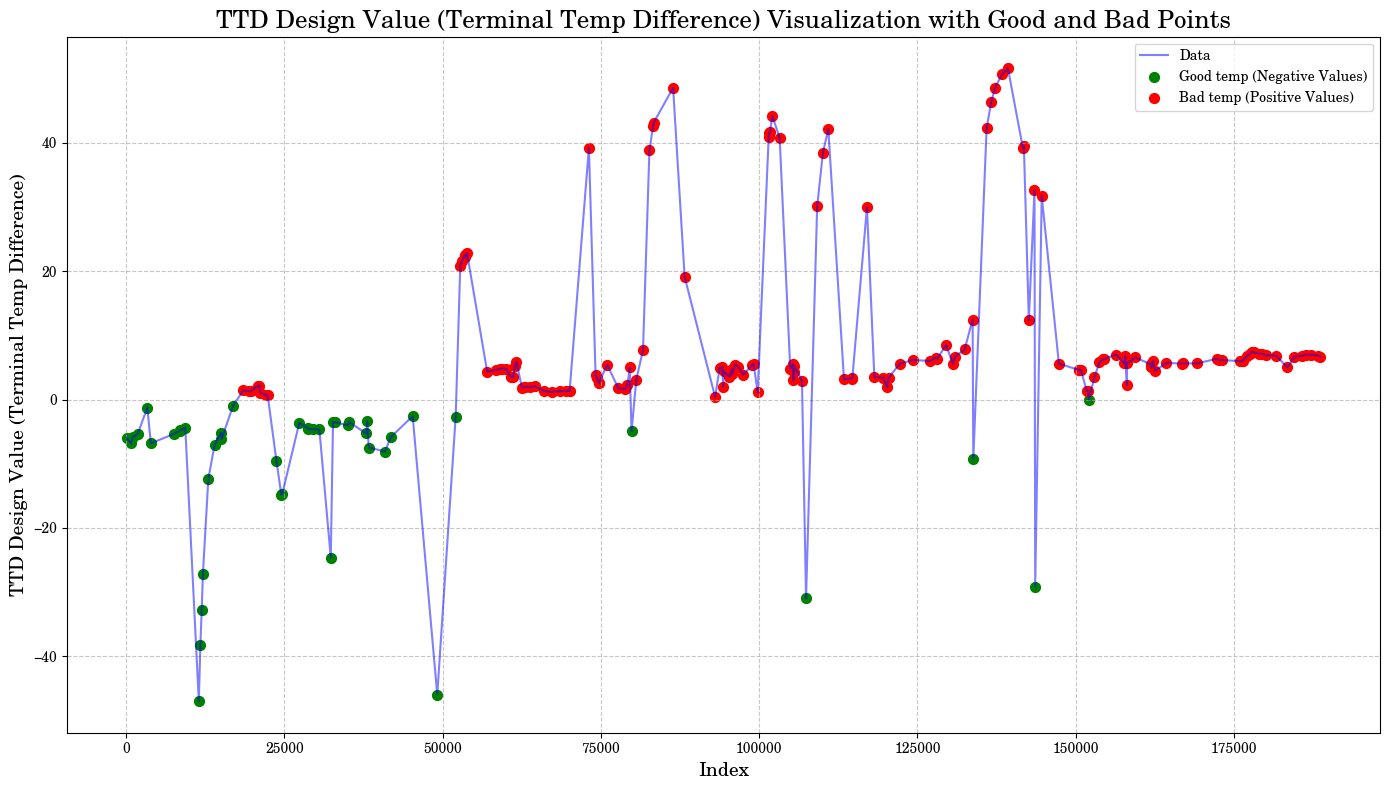

Best sample to represent the data:
Description                                                          06/19/2018 22:30:00
Turbine output                                                                    575.16
Heater 6 MOV open status                                                             0.0
Heate 6 extraction inlet steam temp from heater 9                                  86.57
Heater 6 extraction steam inlet pressure from heater 9                              0.03
Heater 6 condensation level                                                        -0.01
Heater 6 outlet temp to dearator ( drain temp)                                     66.61
Heater 6 outlet drain to deaerator, level control Valve                            -0.02
Heater 6 outlet drain to deaerator, level control Valve emergency                  -0.52
heater # 6 water inlet temp                                                       171.17
heater # 6 water inlet pressure                                            

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Ensure C059 is used
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['C059'] + rcParams['font.serif']

# Load the data
data = pd.read_csv('dara.csv')

# Define the column to visualize
column_name = 'TTD Design Value (Terminal Temp Difference)'

# Sample a smaller subset of the data for better visualization
sampled_data = data.sample(n=200, random_state=42).sort_index()

# Convert the column to numeric values, coercing errors to NaN
sampled_data[column_name] = pd.to_numeric(sampled_data[column_name], errors='coerce')

# Drop rows with NaN values
sampled_data = sampled_data.dropna(subset=[column_name])

# Identify good and bad points
good_points = sampled_data[sampled_data[column_name] < 0]
bad_points = sampled_data[sampled_data[column_name] > 0]

# Plot the data
plt.figure(figsize=(14, 8))
plt.plot(sampled_data.index, sampled_data[column_name], label='Data', color='blue', alpha=0.5)
plt.scatter(good_points.index, good_points[column_name], color='green', label='Good temp (Negative Values)', s=50)
plt.scatter(bad_points.index, bad_points[column_name], color='red', label='Bad temp (Positive Values)', s=50)

# Customize the plot
plt.title(f'{column_name} Visualization with Good and Bad Points', fontsize=18, family='C059')
plt.xlabel('Index', fontsize=14, family='C059')
plt.ylabel(column_name, fontsize=14, family='C059')
plt.xticks(fontsize=10, family='C059')
plt.yticks(fontsize=10, family='C059')
plt.legend(fontsize=10, prop={'family': 'C059'})
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

# Pick the best sample to represent the data
best_sample = sampled_data.loc[sampled_data[column_name].idxmin()]
print("Best sample to represent the data:")
print(best_sample)

In [20]:
import matplotlib.font_manager as fm
print(fm.findSystemFonts(fontpaths=None, fontext='ttf'))


['/usr/share/fonts/truetype/msttcorefonts/ariali.ttf', '/usr/share/fonts/truetype/msttcorefonts/courbd.ttf', '/usr/share/fonts/truetype/noto/NotoSerifTamil-Regular.ttf', '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf', '/usr/share/fonts/truetype/noto/NotoSansBalinese-Bold.ttf', '/usr/share/fonts/truetype/noto/NotoLoopedThai-Regular.ttf', '/usr/share/fonts/truetype/noto/NotoSansOldPermic-Regular.ttf', '/usr/share/fonts/truetype/noto/NotoSansGujarati-Bold.ttf', '/usr/share/fonts/opentype/urw-base35/C059-Bold.otf', '/usr/share/fonts/truetype/msttcorefonts/andalemo.ttf', '/usr/share/fonts/truetype/msttcorefonts/timesi.ttf', '/home/admincit/.fonts/CustomTkinter_shapes_font.otf', '/usr/share/fonts/truetype/noto/NotoSansSoyombo-Regular.ttf', '/usr/share/fonts/truetype/liberation/LiberationMono-BoldItalic.ttf', '/usr/share/fonts/truetype/noto/NotoSansSylotiNagri-Regular.ttf', '/usr/share/fonts/truetype/noto/NotoSansAdlam-Regular.ttf', '/usr/share/fonts/truetype/noto/NotoSansBhaiksuki-Regular

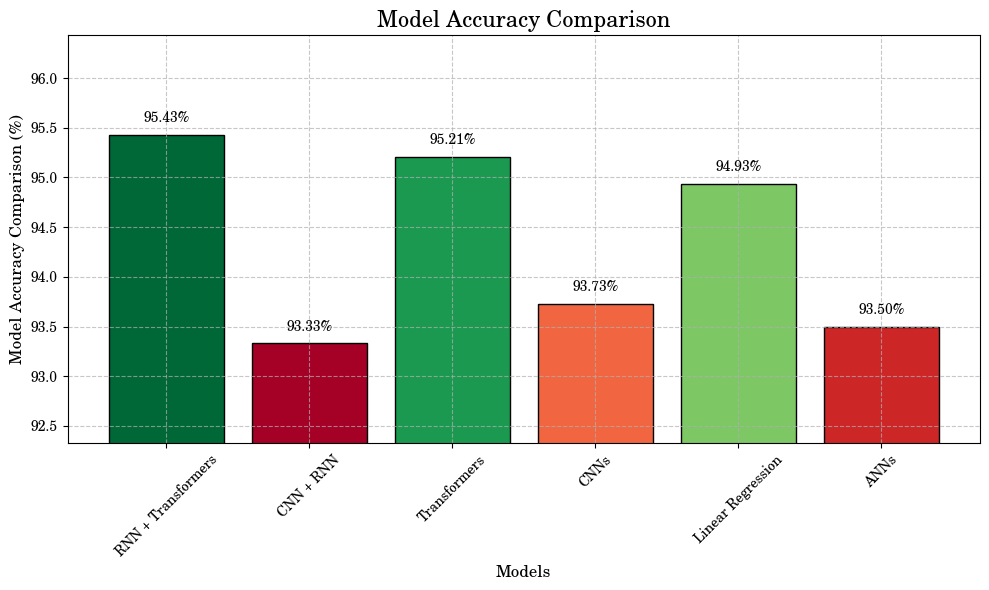

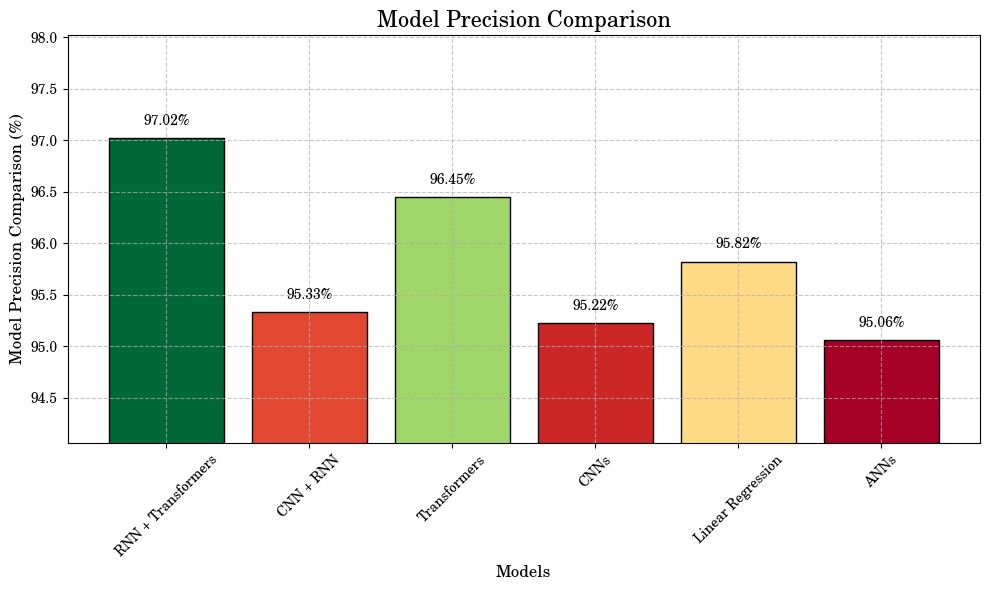

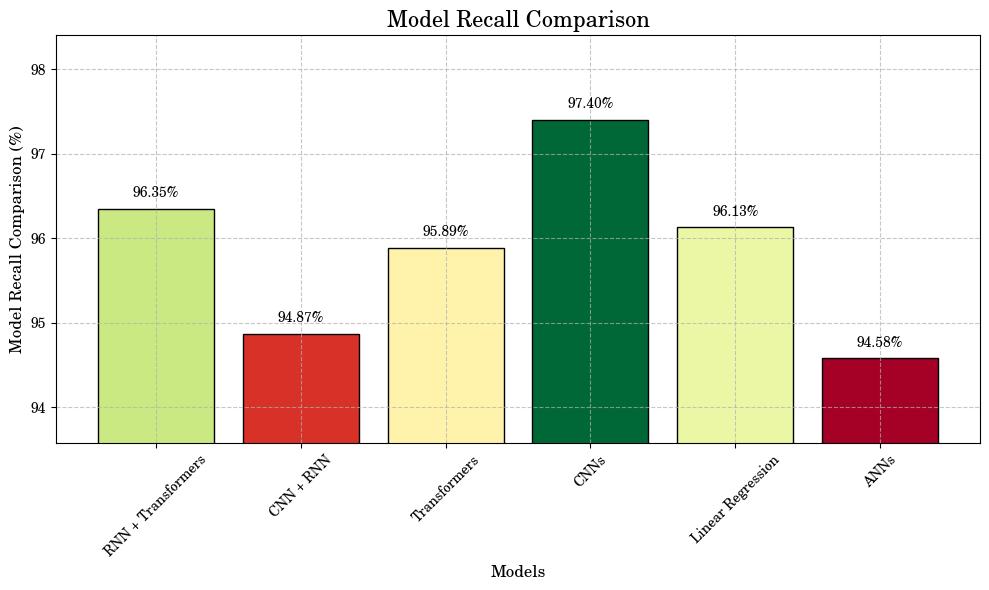

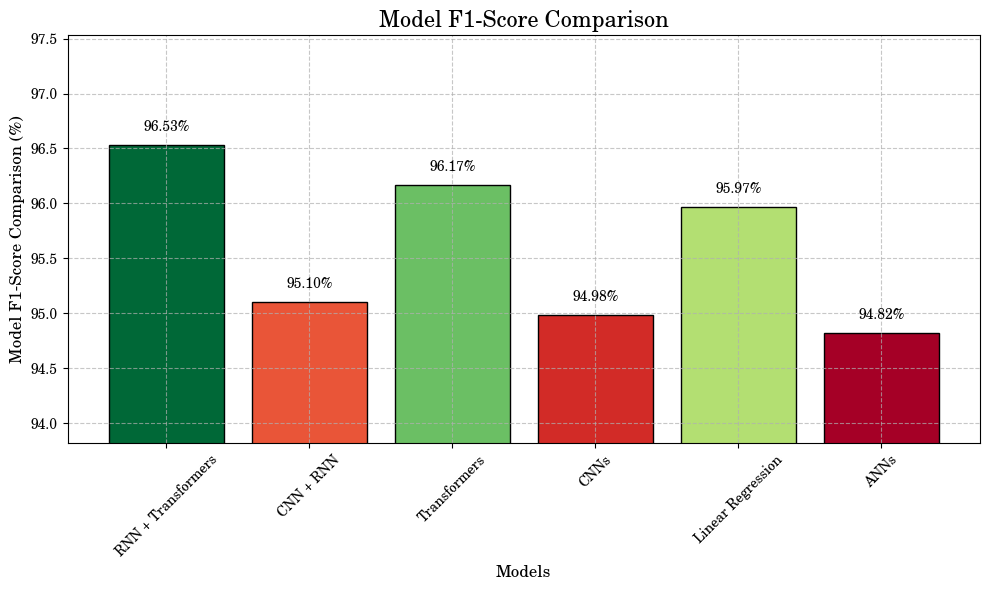

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Define the models and their performance metrics
models = ['RNN + Transformers', 'CNN + RNN', 'Transformers', 'CNNs', 'Linear Regression', 'ANNs']
accuracy = [95.43, 93.33, 95.21, 93.73, 94.93, 93.5]
precision = [97.02, 95.33, 96.45, 95.22, 95.82, 95.06]
recall = [96.35, 94.87, 95.89, 97.4, 96.13, 94.58]
f1_score = [96.53, 95.1, 96.17, 94.98, 95.97, 94.82]

# Function to create bar graph
def create_bar_graph(metric, values, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Determine colors based on values
    norm = plt.Normalize(min(values), max(values))
    colors = plt.cm.RdYlGn(norm(values))
    
    bars = ax.bar(models, values, color=colors, edgecolor='black')
    
    # Add value labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, f'{yval:.2f}%', ha='center', va='bottom', fontsize=10, family='C059')
    
    ax.set_title(title, fontsize=16, family='C059')
    ax.set_ylabel(f'{title} (%)', fontsize=12, family='C059')
    ax.set_xlabel('Models', fontsize=12, family='C059')
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10, family='C059', rotation=45)
    plt.yticks(fontsize=10, family='C059')
    plt.ylim(min(values) - 1, max(values) + 1)  # Adjust y-axis limits to better show differences
    plt.tight_layout()
    plt.show()

# Create bar graphs for each metric
create_bar_graph('Accuracy', accuracy, 'Model Accuracy Comparison')
create_bar_graph('Precision', precision, 'Model Precision Comparison')
create_bar_graph('Recall', recall, 'Model Recall Comparison')
create_bar_graph('F1-Score', f1_score, 'Model F1-Score Comparison')
